<a href="https://colab.research.google.com/github/joaquinvvelaco/diplo-datos-2022/blob/main/deeplearning/entregable/TP_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones
## Trabajo práctico - Materia optativa Deeplearning - 2022

## Integrantes
- Nicolas Davia
- Joaquín Velasco

## Librerías

In [ ]:
import gzip
import mlflow
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import bz2

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange
from sklearn.metrics import balanced_accuracy_score

## Dataset

Se utilizará el dataset MELI Challenge 2019

In [ ]:
tokens = pd.read_json("./data/meli-challenge-2019/spanish_token_to_index.json.gz", lines=True)

In [ ]:
token_dict = dict()

for column in tokens.columns:
    token_dict[column] = tokens[column].values[0]

In [ ]:
token_dict

{'barbies': 50000,
 'casita': 50001,
 'muñecas': 2,
 'pintadas': 3,
 'cromado': 4,
 'holográfico': 5,
 'neceser': 6,
 'asiento': 7,
 'chevrolet': 8,
 'funda': 9,
 'medida': 10,
 'embrague': 11,
 'focus': 12,
 'ford': 13,
 'one': 14,
 'bateria': 15,
 'dmc': 16,
 'dmwbcf': 17,
 'lumix': 18,
 'panasonic': 19,
 'harman': 20,
 'kardon': 21,
 'network': 22,
 'receiver': 23,
 'pack': 24,
 'duo': 25,
 'essen': 26,
 'olla': 27,
 'bluetooth': 28,
 'mini': 29,
 'teclado': 30,
 'acordeón': 31,
 'alemán': 32,
 'bajos': 33,
 'weltmeister': 34,
 'autolevel': 35,
 'impresora': 36,
 'lista': 37,
 'plus': 38,
 'prusa': 39,
 'usar': 40,
 'adaptador': 41,
 'cargador': 42,
 'corriente': 43,
 'general': 44,
 'par': 45,
 'puertos': 46,
 'usb': 47,
 'andador': 48,
 'love': 49,
 'musical': 50,
 'agatha': 51,
 'brillo': 52,
 'frutti': 53,
 'labial': 54,
 'prada': 55,
 'ruiz': 56,
 'sabor': 57,
 'tutti': 58,
 'ancho': 59,
 'batista': 60,
 'estampada': 61,
 'tela': 62,
 'bomberos': 63,
 'dept': 64,
 'engine': 65,

In [ ]:
train_dataset = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz', lines=True,  orient="records", chunksize=1000000)], ignore_index=True)
test_dataset = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.test.jsonl.gz', lines=True,  orient="records", chunksize=1000000)], ignore_index=True)

Tomamos una muestra del ~10% del dataset original para disminuir los tiempos de entrenamiento y procesamiento. Consideramos que utilizando la totalidad de los datos podrían obtenerse mejores resultados.

In [ ]:
train_dataset = train_dataset.sample(n = 500000, random_state = 0,ignore_index=True) 
#test_dataset = test_dataset.sample(n = 500000, random_state = 0,ignore_index=True) 

In [ ]:
train_dataset.head()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280


In [ ]:
len(train_dataset["target"].unique())

632

## Clases

Definimos las clases que encapsulan la lógica para operar con un dataset de pytorch y preprocesarlo.

In [ ]:
DATA_VARIABLE_NAME = "title"
TARGET_VARIABLE_NAME = "category"

In [ ]:
class MeliDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, DATA_VARIABLE_NAME],
            "target": self.dataset.loc[item, TARGET_VARIABLE_NAME]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

In [ ]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        

        self.dictionary = corpora.Dictionary(
            dataset[DATA_VARIABLE_NAME].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset[TARGET_VARIABLE_NAME].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

Instanciamos los objetos MeliDataset

In [ ]:
train_prepoccessor = RawDataProcessor(train_dataset)
test_prepoccessor = RawDataProcessor(test_dataset)

meli_train_dataset = MeliDataset(train_dataset.reset_index(drop=True), transform=train_prepoccessor)
meli_test_dataset = MeliDataset(test_dataset.reset_index(drop=True), transform=test_prepoccessor)

print(f"Datasets loaded with {len(meli_train_dataset)} training elements and {len(meli_test_dataset)} test elements")
print(f"Sample train element:\n{meli_train_dataset[0]}")

Datasets loaded with 4895280 training elements and 63680 test elements
Sample train element:
{'data': [50001, 2, 50000, 3], 'target': 188}


In [ ]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [ ]:
pad_sequences = PadSequences()
train_loader = DataLoader(meli_train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(meli_test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)

Definimos las funciones train(), evaluate(), save_mlflow() y run_experiment() para reutilizar código en la ejecución de cada experimento

In [ ]:
def train(model, loss, optimizer, trainloader, epoch, mlflow, device):
    model.train()
    running_loss = []
    targets = []
    predictions = []
    for idx, batch in enumerate(tqdm(train_loader)):
        inputs = batch['data'].to(device)
        labels = batch['target'].to(device)
        
        optimizer.zero_grad()
        output = model(inputs)
        
        _, predicted = torch.max(output.data, 1)
            
        targets.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        
        loss_value = loss(output, labels.squeeze().long())
        loss_value.backward()
        optimizer.step()
        running_loss.append(loss_value.item())        
    mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
    mlflow.log_metric("train_balanced_accuracy", balanced_accuracy_score(targets, predictions), epoch)


In [ ]:
def evaluate(model, loss, optimizer, test_loader, epoch, mlflow, device):
    model.eval()
    running_loss = []
    targets = []
    predictions = []
    for batch in tqdm(test_loader):
        inputs = batch['data'].to(device)
        labels = batch['target'].to(device)
        output = model(inputs)
        _, predicted = torch.max(output.data, 1)
                
        loss_value = loss(output, labels.squeeze().long())
        running_loss.append(loss_value.item())
        
        targets.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

        
    mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
    mlflow.log_metric("test_balanced_accuracy", balanced_accuracy_score(targets, predictions), epoch)

In [ ]:
def save_mlflow(model, test_loader, mlflow, device):
    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            inputs = batch['data'].to(device)
            labels = batch['target'].to(device)
            output = model(inputs)
            targets.extend(labels.cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions_{model.name}.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions_{model.name}.csv.gz")

In [ ]:
def run_experiment(model, trainloader, testloader, loss, optimizer, epochs, device):
    model.to(device)
    mlflow.set_experiment(f"MELI experiment - {model.name}")
    with mlflow.start_run():
        mlflow.log_param("model_name", model.name)
        mlflow.log_param("freeze_embedding", True)
        mlflow.log_params(model.layers_info())
        for epoch in range(epochs):
            train(model, loss, optimizer, trainloader, epoch, mlflow, device)
            evaluate(model, loss, optimizer, testloader, epoch, mlflow, device)
        save_mlflow(model, test_loader, mlflow, device)

In [ ]:
def embeddings(pretrained_embeddings_path, dictionary, vector_size, freeze_embedings):
    embeddings_matrix = torch.randn(len(dictionary), vector_size)
    embeddings_matrix[0] = torch.zeros(vector_size)
    with bz2.open(pretrained_embeddings_path, "rt") as fh:
        for line in fh:
            word, vector = line.strip().split(None, 1)
            if word in dictionary:
                embeddings_matrix[dictionary[word]] =\
                    torch.FloatTensor([float(n) for n in vector.split()])
    return nn.Embedding.from_pretrained(embeddings_matrix,
                                                   freeze=freeze_embedings,
                                                   padding_idx=0)


Importamos los embeddings e instanciamos la capa de embeddings para reutilizarla en los diferentes modelos

In [ ]:
vector_size = 300

In [ ]:
embeddings_layer = embeddings("./data/SBW-vectors-300-min5.txt.bz2", token_dict, vector_size, True)
test_embeddings_layer = nn.Embedding(len(token_dict), vector_size, 0)

In [ ]:
def nothing(x):
    return x

## Modelos MLP

Definimos las entidades para construir una red neuronal parametrizable por:
* Cantidad de capas
* Cantidad de neuronas por capas
* Tipos de capas y funciones de activación

La clase Layer modela una capa de una red neuronal, la cual puede o no tener función de activación
La clase DeepNeuralNetwork modela una red neuronal profunda y recibe como parametros las capas que la componen

In [ ]:

class Layer():
    def __init__(self, function, activation=None):
        self.function = function
        self.activation = activation

    def run(self, x):
        output = self.function(x)
        output = self.activation(output)

        return output
    

class DeepNeuralNetwork(nn.Module):
    def __init__(self, 
                 embeddings,
                 vector_size,
                 layers,
                 name,
                ):
        super().__init__()

        self.embeddings = embeddings

        self.layers = nn.ModuleList([layer.function for layer in layers])
        self.activations = [layer.activation for layer in layers]

        self.name = name
        self.vector_size = vector_size
        
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.activations[i](x)
            
        return x
    
    def layers_info(self):
        layers_info = {}
        layers_info["embedding_size"] = self.vector_size #hardcode
        for i, layer in enumerate(self.layers):
            layers_info[f"layer_{i+1}_input"] = layer.in_features 
            layers_info[f"layer_{i+1}_output"] = layer.out_features 
        return layers_info
        

Definimos la variable device para utilizar la GPU durante la ejecución del experimento

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Instanciamos el modelo MLP1 con configuración:
- Capa de embeddings de 300 dim
- Primera capa oculta de 300 in y 512 out con activación Relu
- Segunda capa oculta de 512 in y 1024 out con activación Relu
- Capa de salida de 1024 in y 632 out con activación Softmax

In [ ]:
model = DeepNeuralNetwork(
    embeddings_layer,
    vector_size, 
    [
        Layer(nn.Linear(vector_size, 512), F.relu),
        Layer(nn.Linear(512, 1024), F.relu),
        Layer(nn.Linear(1024, 632), torch.nn.functional.softmax)
    ],
    "MLP1"
)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
run_experiment(model, train_loader, test_loader, loss, optimizer, 7, device)

2022/10/30 22:50:39 INFO mlflow.tracking.fluent: Experiment with name 'MELI experiment - MLP1' does not exist. Creating a new experiment.


  0%|          | 0/3907 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/3907 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/3907 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/3907 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/3907 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/3907 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/3907 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipykernel_2254225/368521811.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i](x)


Instanciamos el modelo MLP2 con configuración:
- Capa de embeddings de 300 dim
- Primer capa oculta de 300 in y 512 out con activación Relu
- Segunda capa oculta de 512 in y 512 out con activación Gelu
- Tercera capa oculta de 512 in y 1024 out con activación Relu
- Capa de salida de 1024 in y 632 out sin activación


In [ ]:
model2 = DeepNeuralNetwork(
    embeddings_layer,
    vector_size, 
    [
        Layer(nn.Linear(vector_size, 512), F.relu),
        Layer(nn.Linear(512, 512), F.gelu),
        Layer(nn.Linear(512, 1024), F.relu),
        Layer(nn.Linear(1024, 632), nothing)
    ],
    "MLP2"
)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-5)
run_experiment(model2, train_loader, test_loader, loss, optimizer, 5, device)

2022/10/30 23:05:27 INFO mlflow.tracking.fluent: Experiment with name 'MELI experiment - MLP2' does not exist. Creating a new experiment.


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Instanciamos el modelo MLP3 con configuración:
- Capa de embeddings de 300 dim
- Primera capa oculta de 300 in y 512 out con activación Relu
- Segunda capa oculta de 512 in y 1024 out con activación Relu
- Capa de salida de 1024 in y 632 out sin activación


In [ ]:
model3 = DeepNeuralNetwork(
    embeddings_layer,
    vector_size, 
    [
        Layer(nn.Linear(vector_size, 512), F.relu),
        Layer(nn.Linear(512, 1024), F.relu),
        Layer(nn.Linear(1024, 632), nothing)
    ],
    "MLP3"
)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-5)
run_experiment(model3, train_loader, test_loader, loss, optimizer, 5, device)

2022/10/30 23:18:17 INFO mlflow.tracking.fluent: Experiment with name 'MELI experiment - MLP3' does not exist. Creating a new experiment.


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Instanciamos el modelo MLP4 con configuración:
- Capa de embeddings de 300 dim
- Primera capa oculta de 300 in y 512 out con activación Relu
- Segunda capa oculta de 512 in y 1024 out con activación Relu
- Capa de salida de 1024 in y 632 out con activación sigmoide


In [ ]:
model4 = DeepNeuralNetwork(
    embeddings_layer,
    vector_size, 
    [
        Layer(nn.Linear(vector_size, 512), F.relu),
        Layer(nn.Linear(512, 1024), F.relu),
        Layer(nn.Linear(1024, 632), torch.sigmoid)
    ],
    "MLP4"
)
optimizer = optim.Adam(model4.parameters(), lr=1e-3, weight_decay=1e-5)
run_experiment(model4, train_loader, test_loader, loss, optimizer, 5, device)

2022/10/30 23:31:50 INFO mlflow.tracking.fluent: Experiment with name 'MELI experiment - MLP4' does not exist. Creating a new experiment.


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Instanciamos el modelo MLP5 con configuración:
- Capa de embeddings de 300 dim
- Primera capa oculta de 300 in y 1024 out con activación Relu
- Segunda capa oculta de 1024 in y 512 out con activación Relu
- Capa de salida de 512 in y 632 out sin activación


In [ ]:
model5 = DeepNeuralNetwork(
    embeddings_layer,
    vector_size, 
    [
        Layer(nn.Linear(vector_size, 1024), F.relu),
        Layer(nn.Linear(1024, 512), F.relu),
        Layer(nn.Linear(512, 632), nothing)
    ],
    "MLP5"
)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=1e-3, weight_decay=1e-5)
run_experiment(model5, train_loader, test_loader, loss, optimizer, 5, device)

2022/10/30 23:46:09 INFO mlflow.tracking.fluent: Experiment with name 'MELI experiment - MLP5' does not exist. Creating a new experiment.


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Instanciamos el modelo MLP6 con configuración:
- Capa de embeddings de 300 dim
- Primera capa oculta de 300 in y 512 out con activación Relu
- Segunda capa oculta de 512 in y 1024 out con activación Relu
- Tercera capa oculta de 1024 in y 1024 out con activación Relu
- Cuarta capa oculta de 1024 in y 512 out con activación Relu
- Capa de salida de 512 in y 632 out sin activación


In [ ]:
model6 = DeepNeuralNetwork(
    embeddings_layer,
    vector_size, 
    [
        Layer(nn.Linear(vector_size, 512), F.relu),
        Layer(nn.Linear(512, 1024), F.relu),
        Layer(nn.Linear(1024, 1024), F.relu),
        Layer(nn.Linear(1024, 512), F.relu),
        Layer(nn.Linear(512, 632), nothing)
    ],
    "MLP6"
)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model6.parameters(), lr=1e-3, weight_decay=1e-5)
run_experiment(model6, train_loader, test_loader, loss, optimizer, 5, device)

2022/10/30 23:59:45 INFO mlflow.tracking.fluent: Experiment with name 'MELI experiment - MLP6' does not exist. Creating a new experiment.


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

## Métricas y reportes de modelos MLP

### Tiempos de ejecución

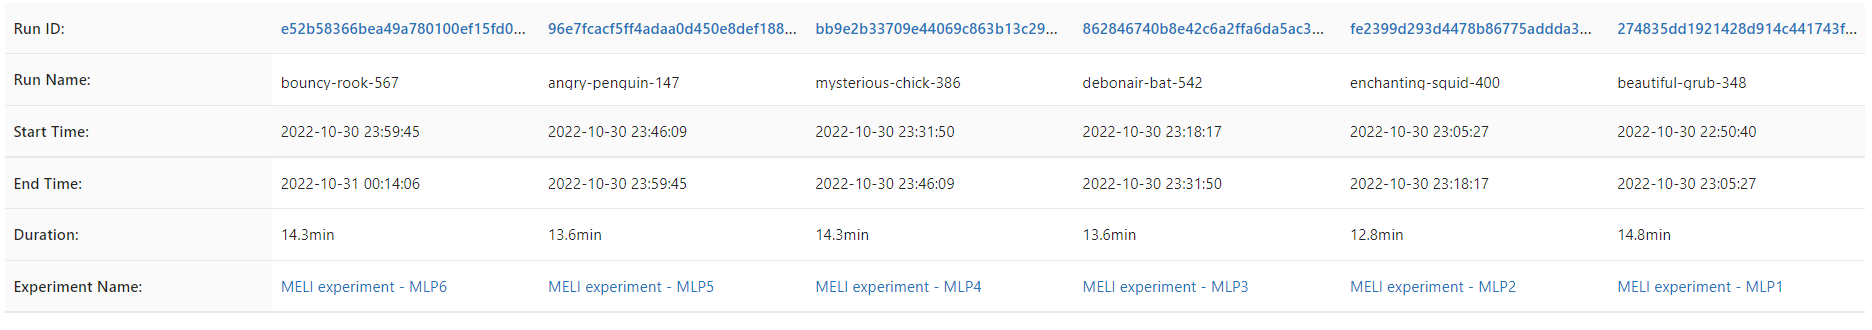

### MLP1

#### Balanced Accuracy

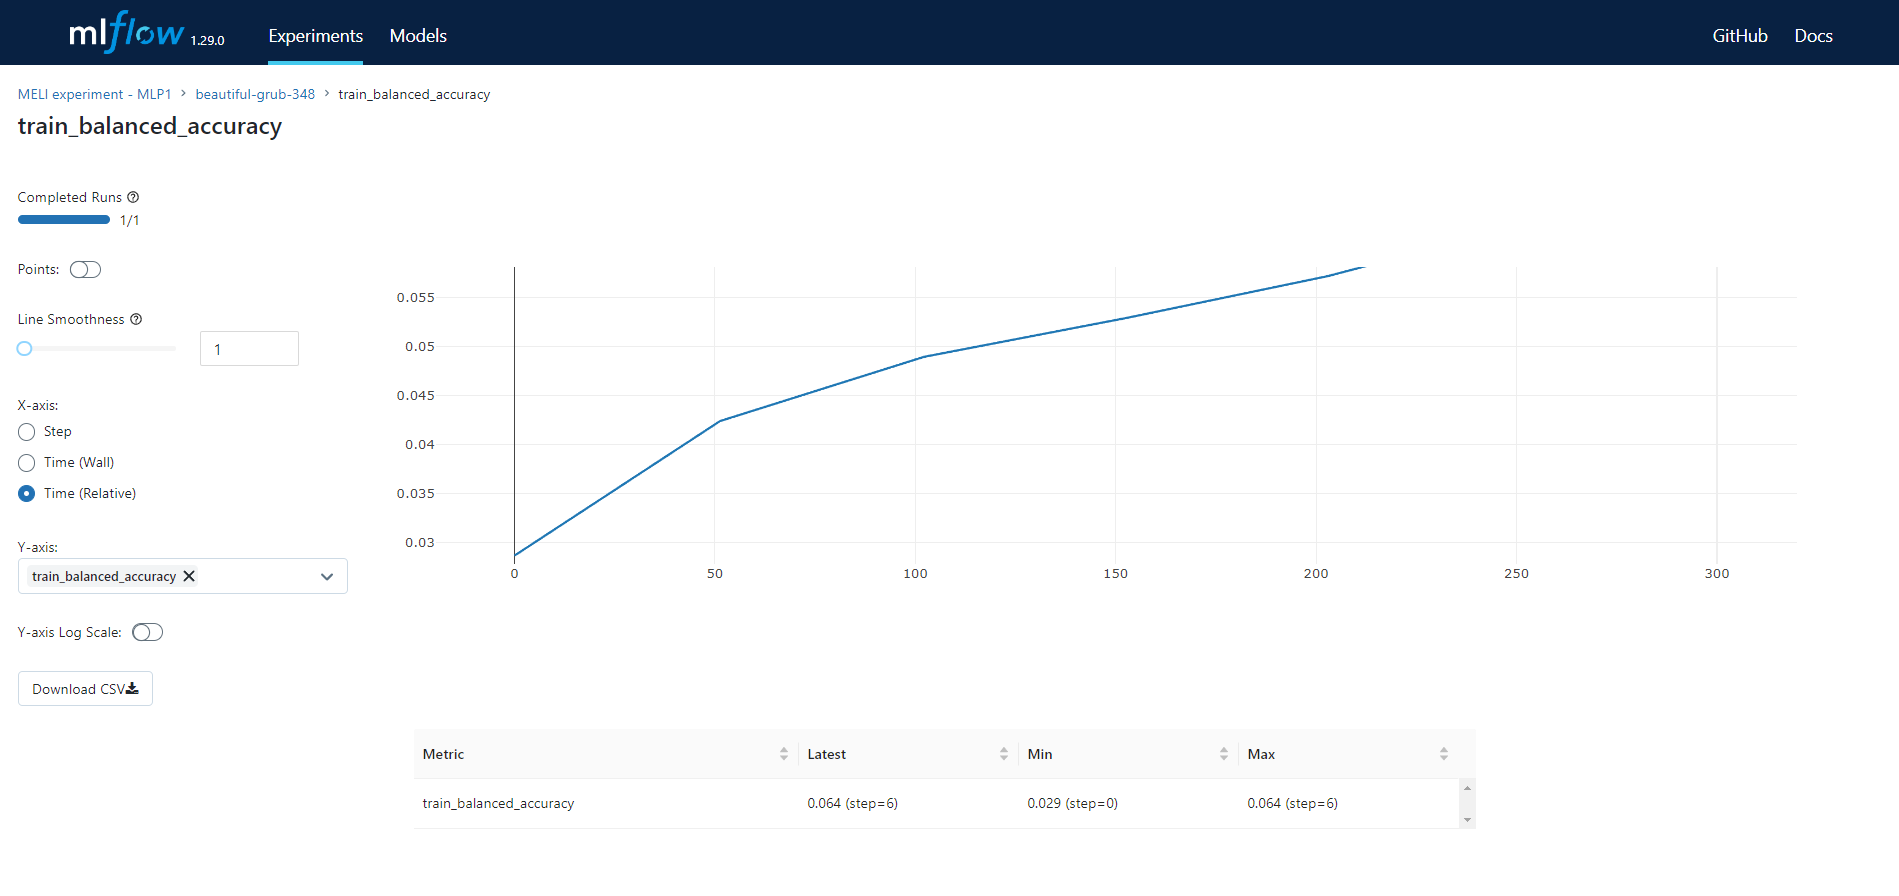

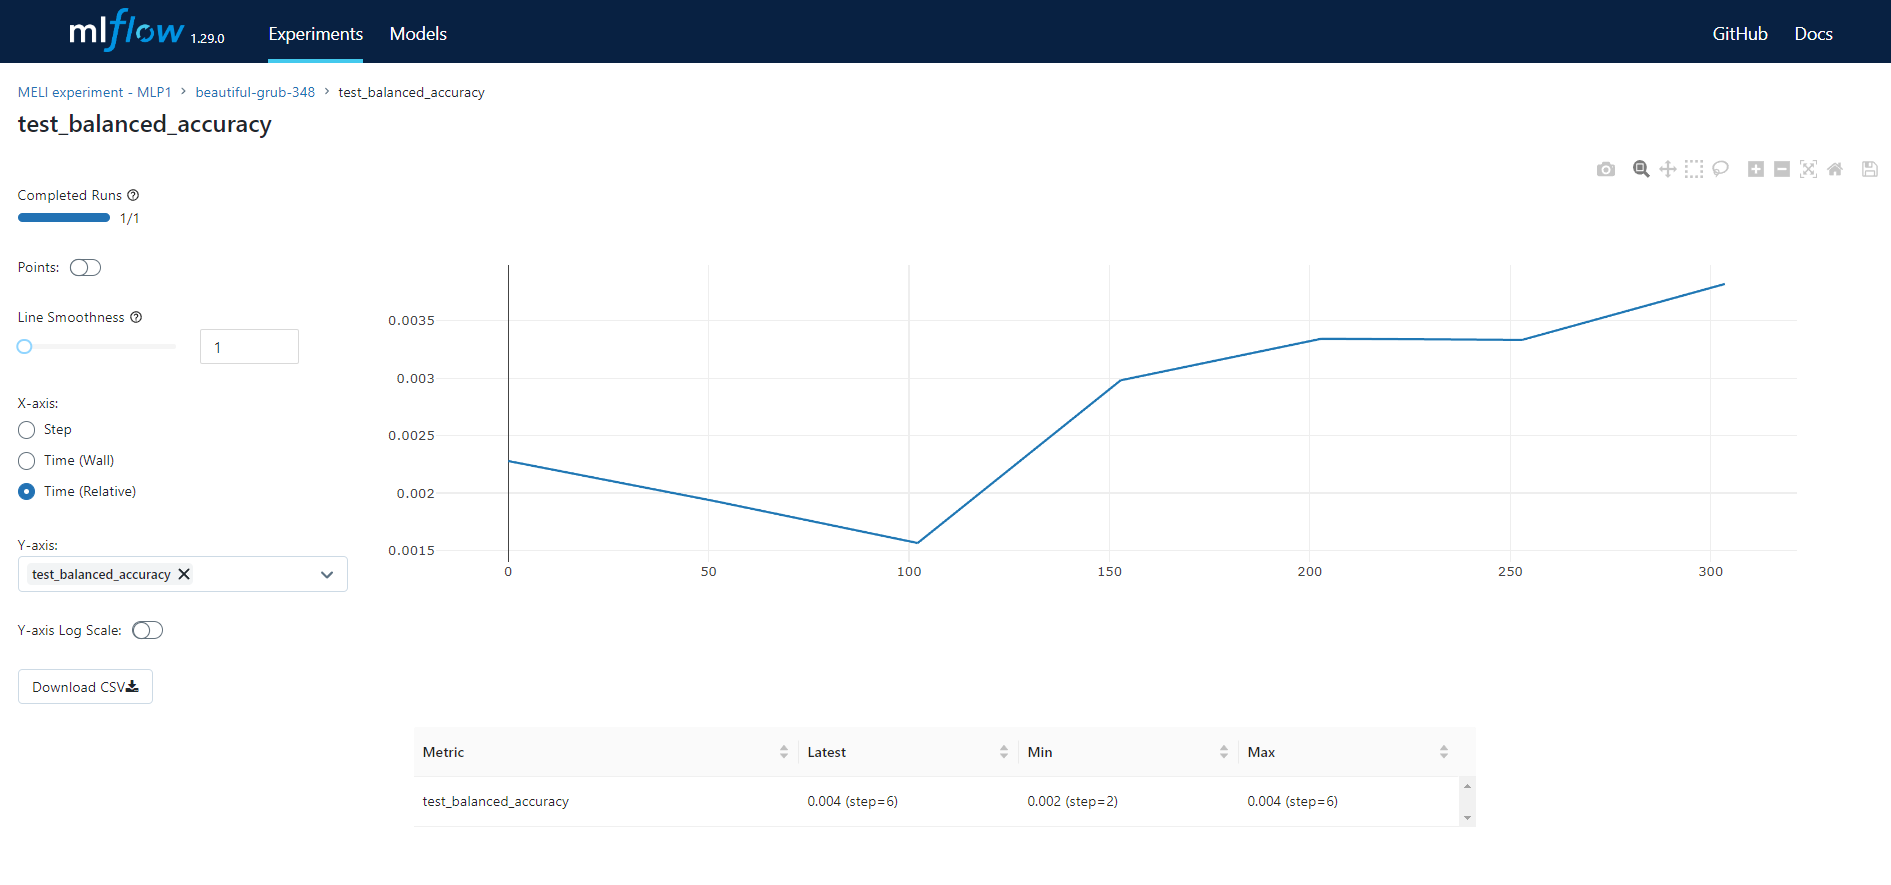

#### Loss

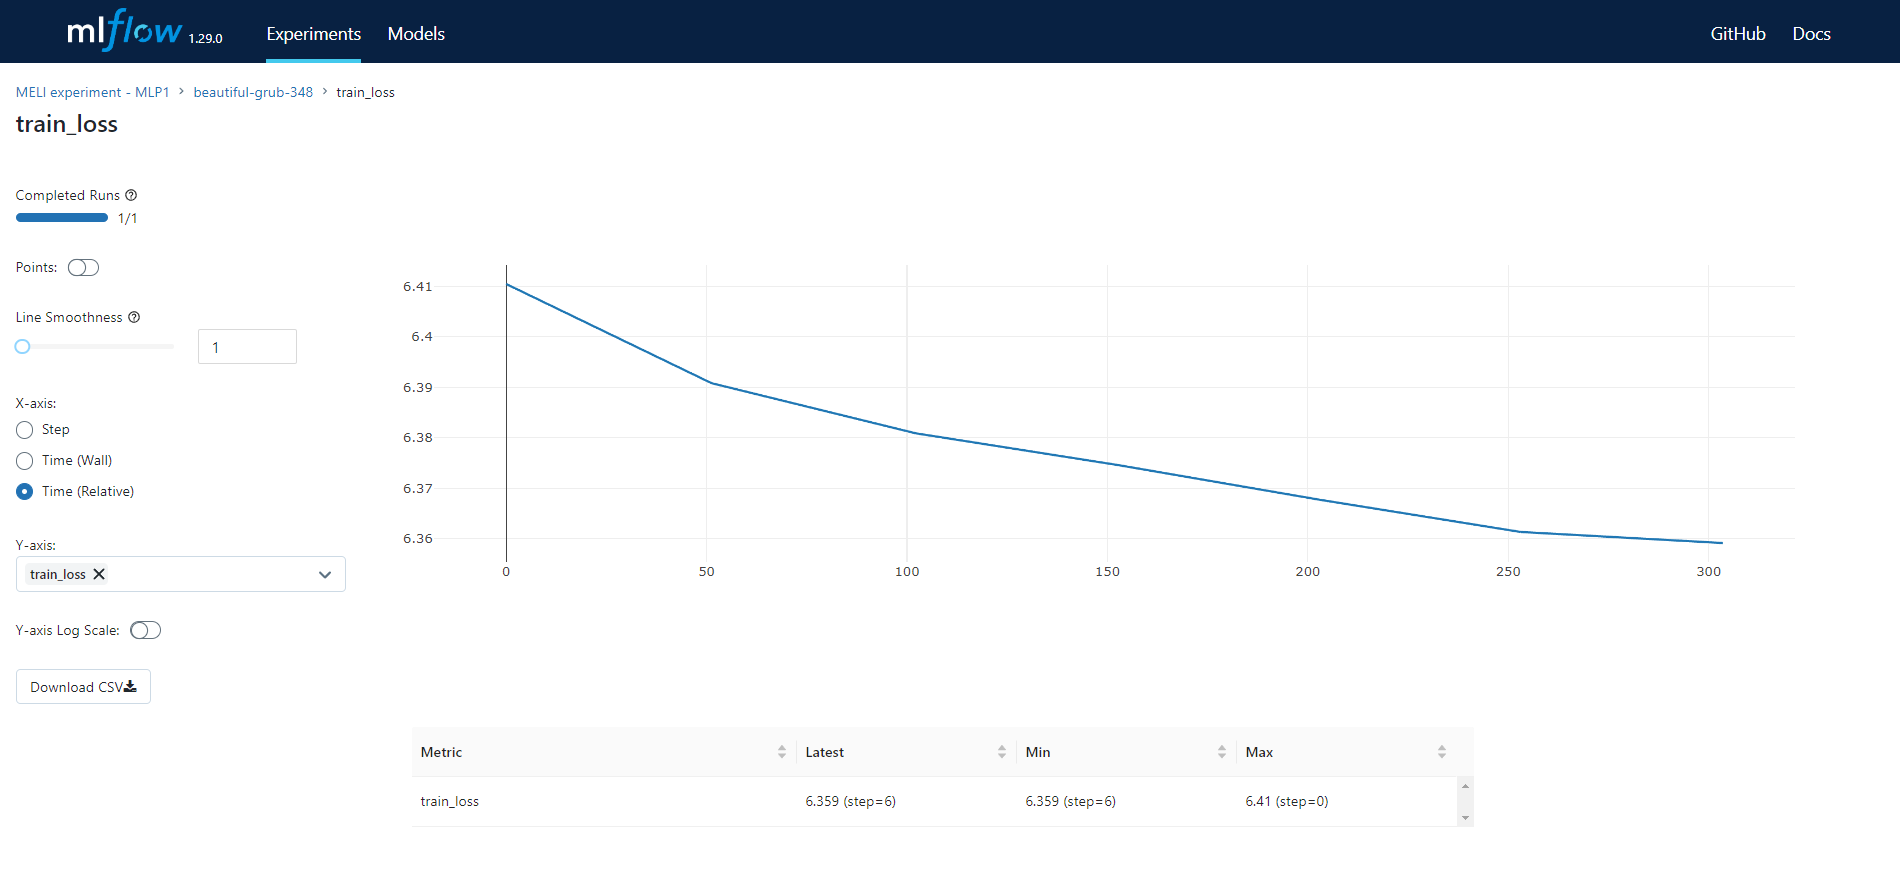

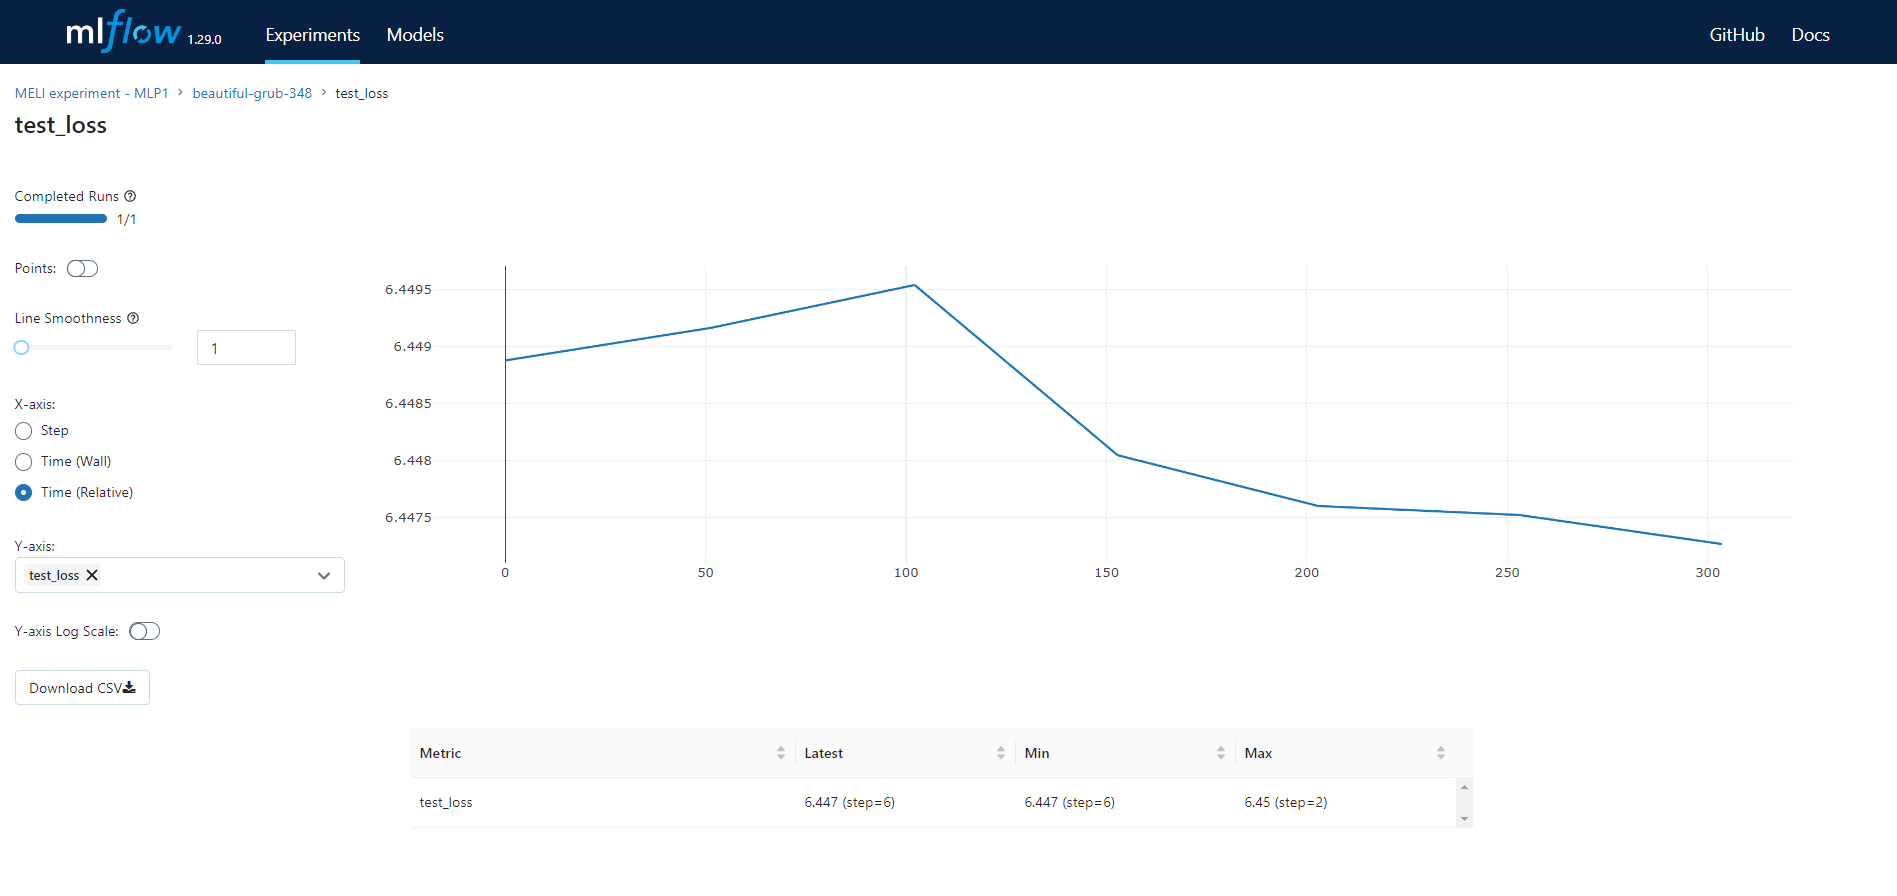

### MLP2

#### Balanced Accuracy

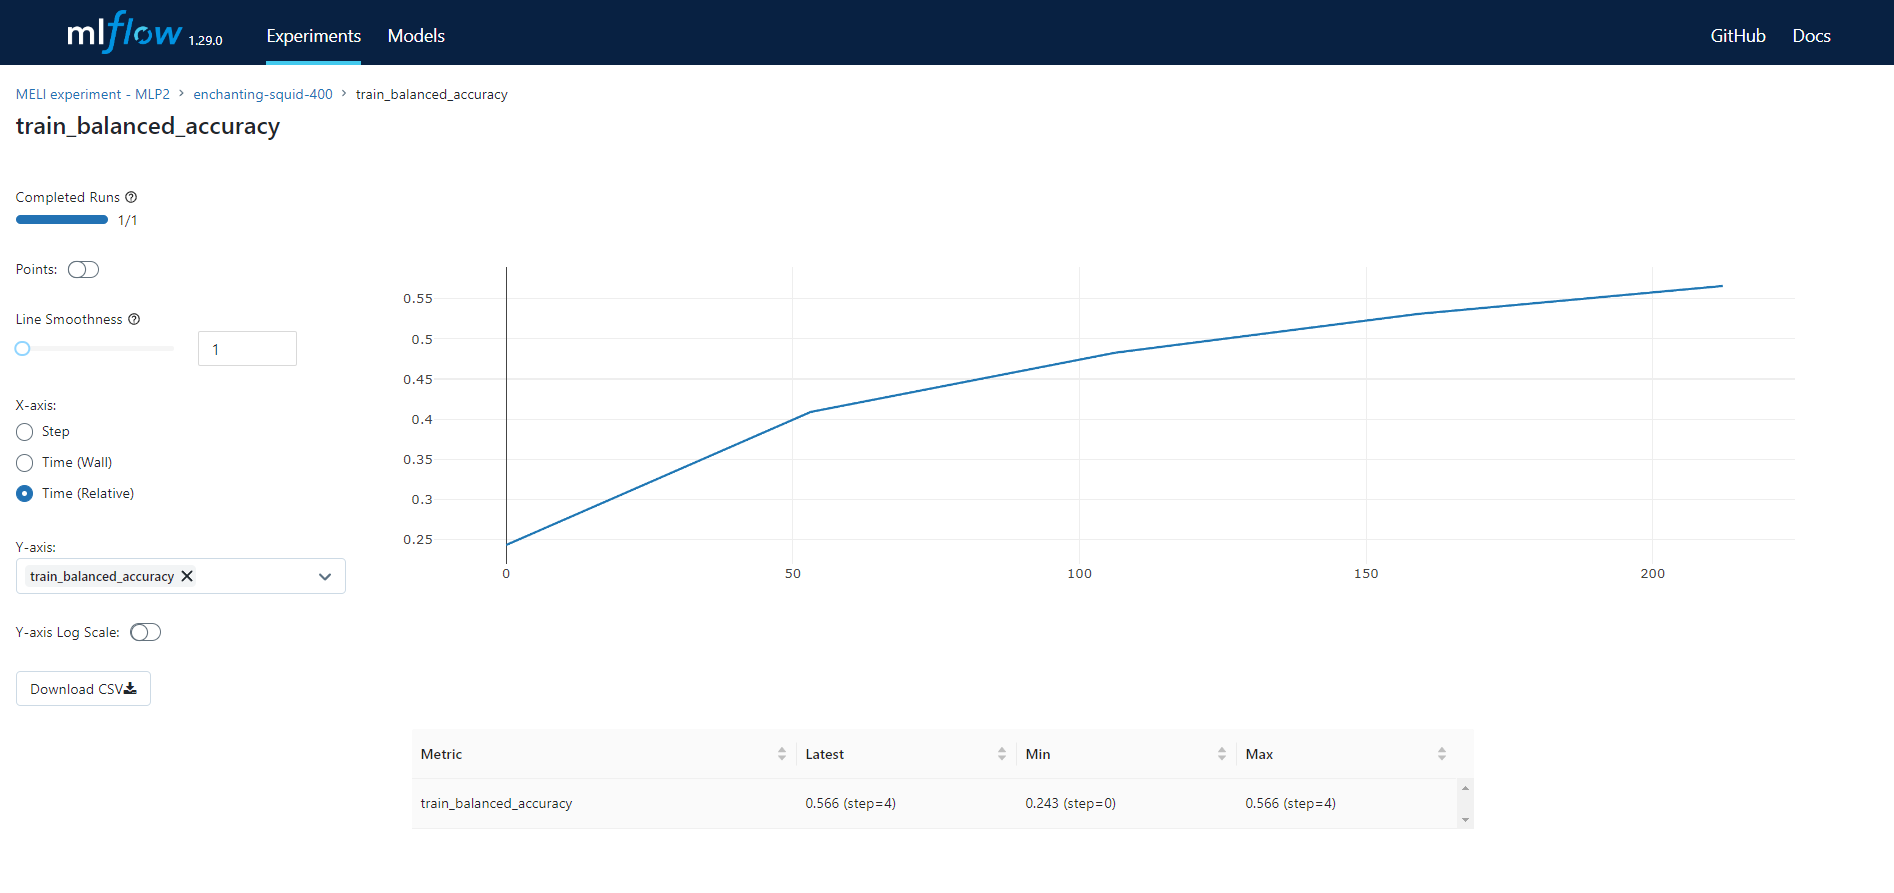

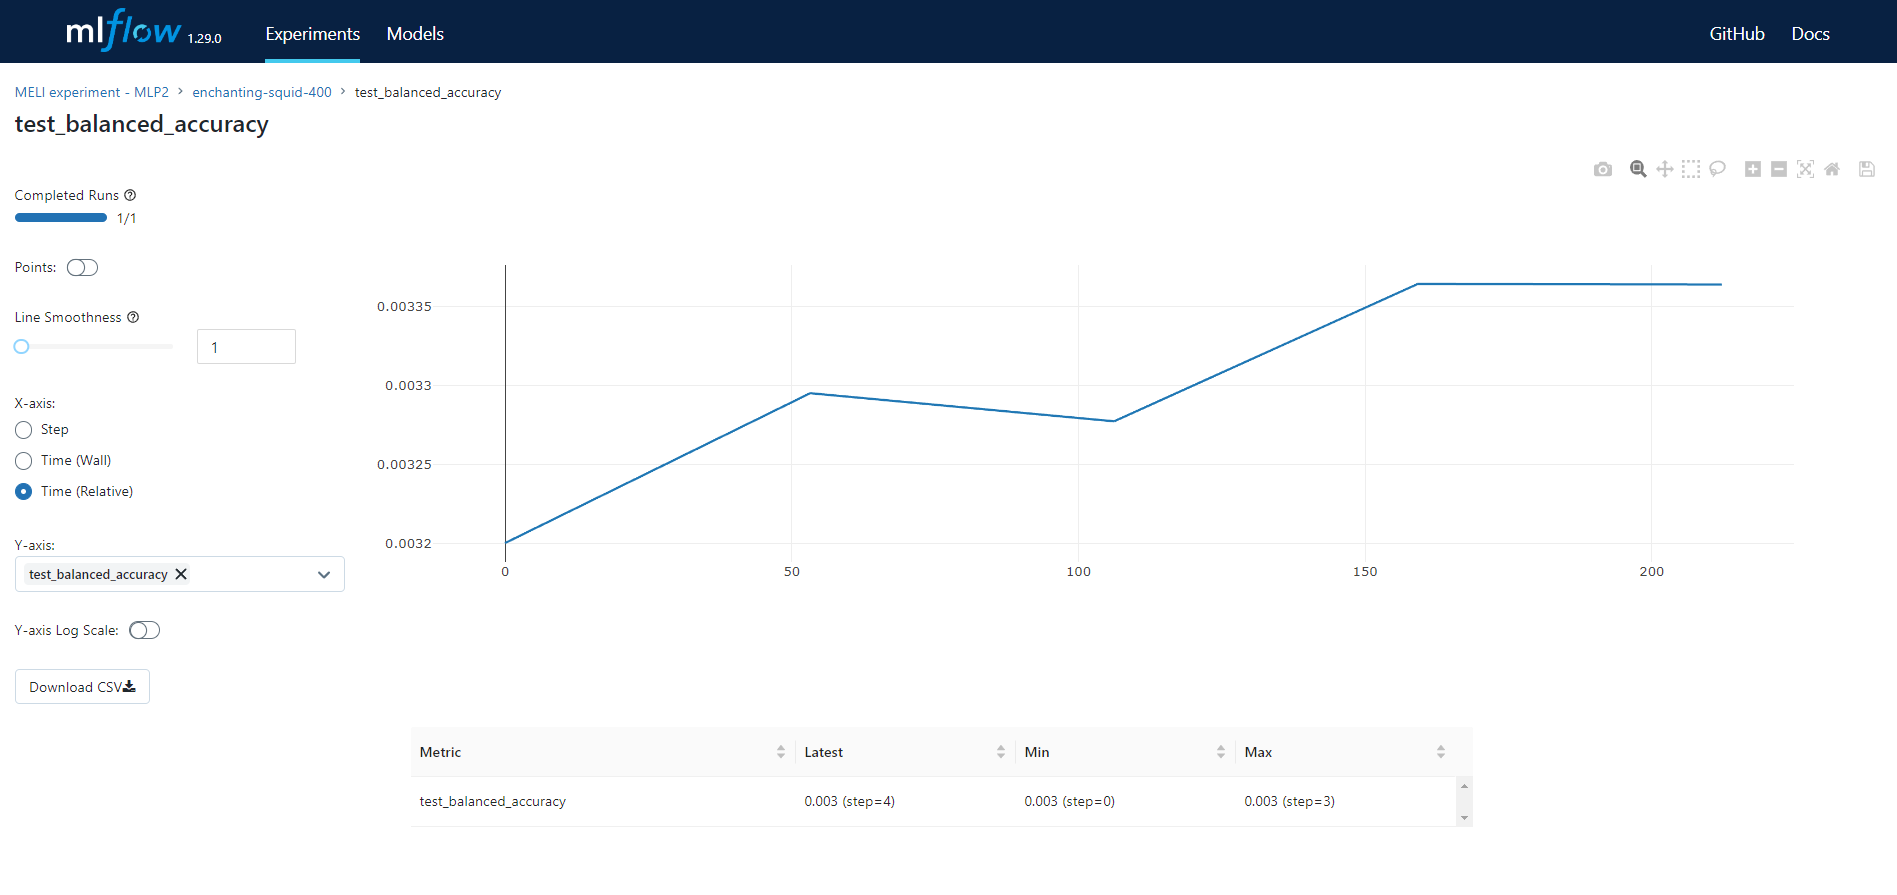

#### Loss

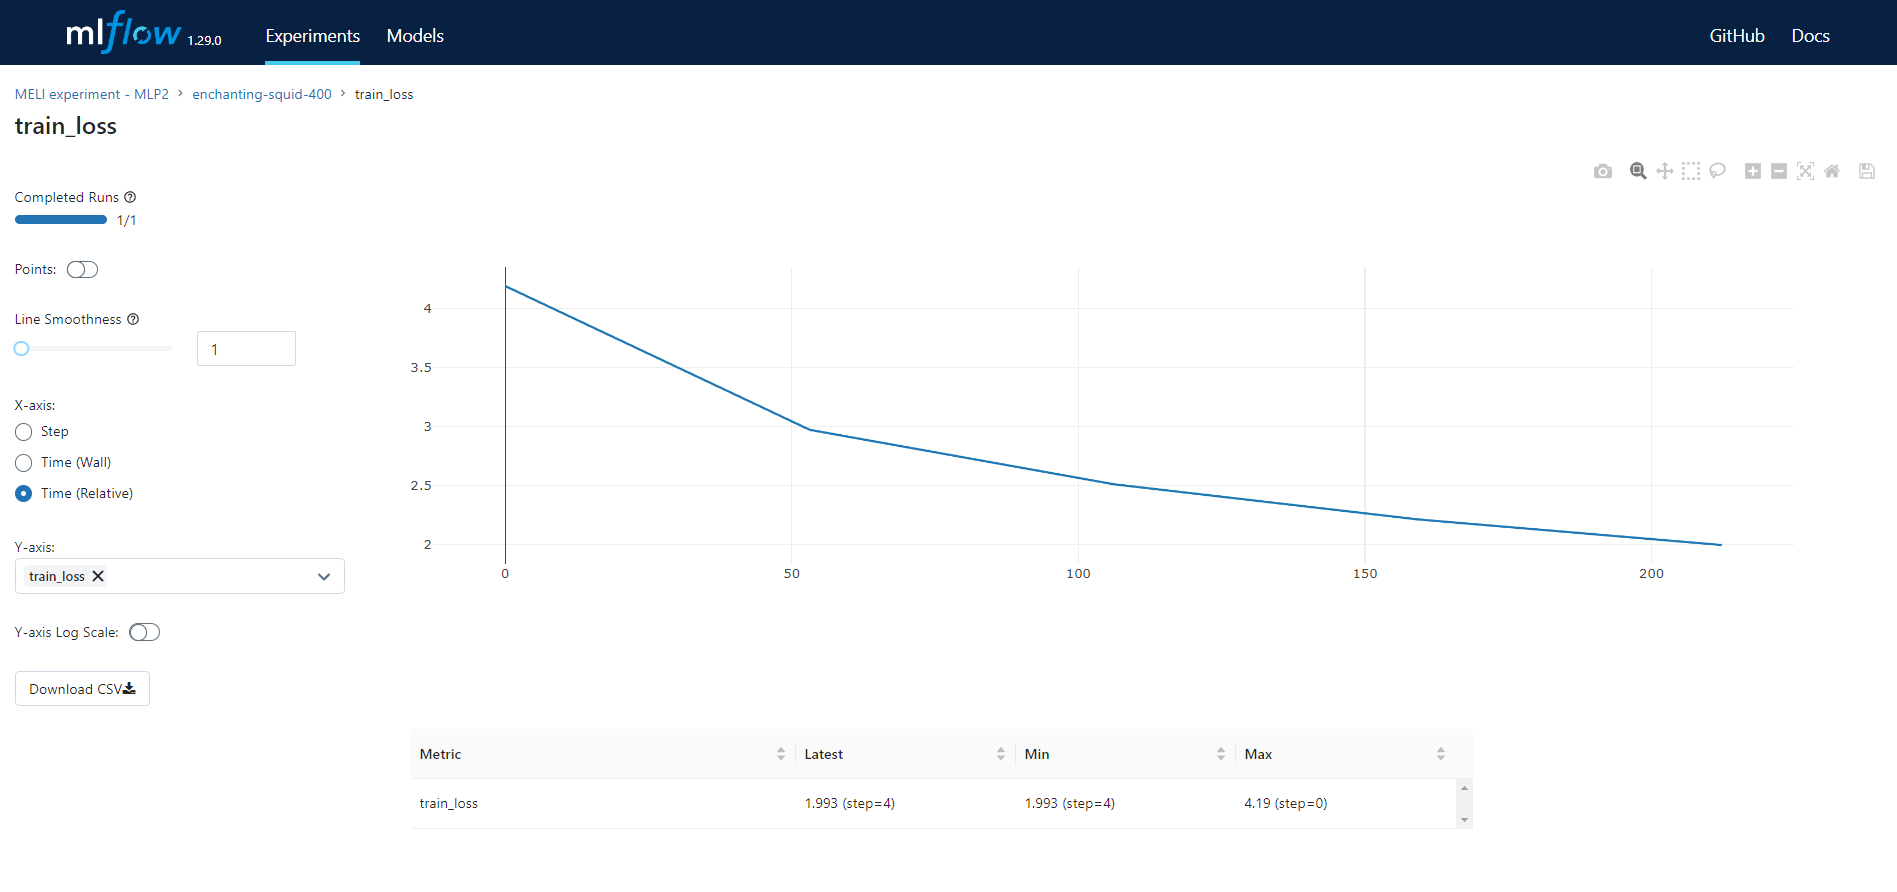

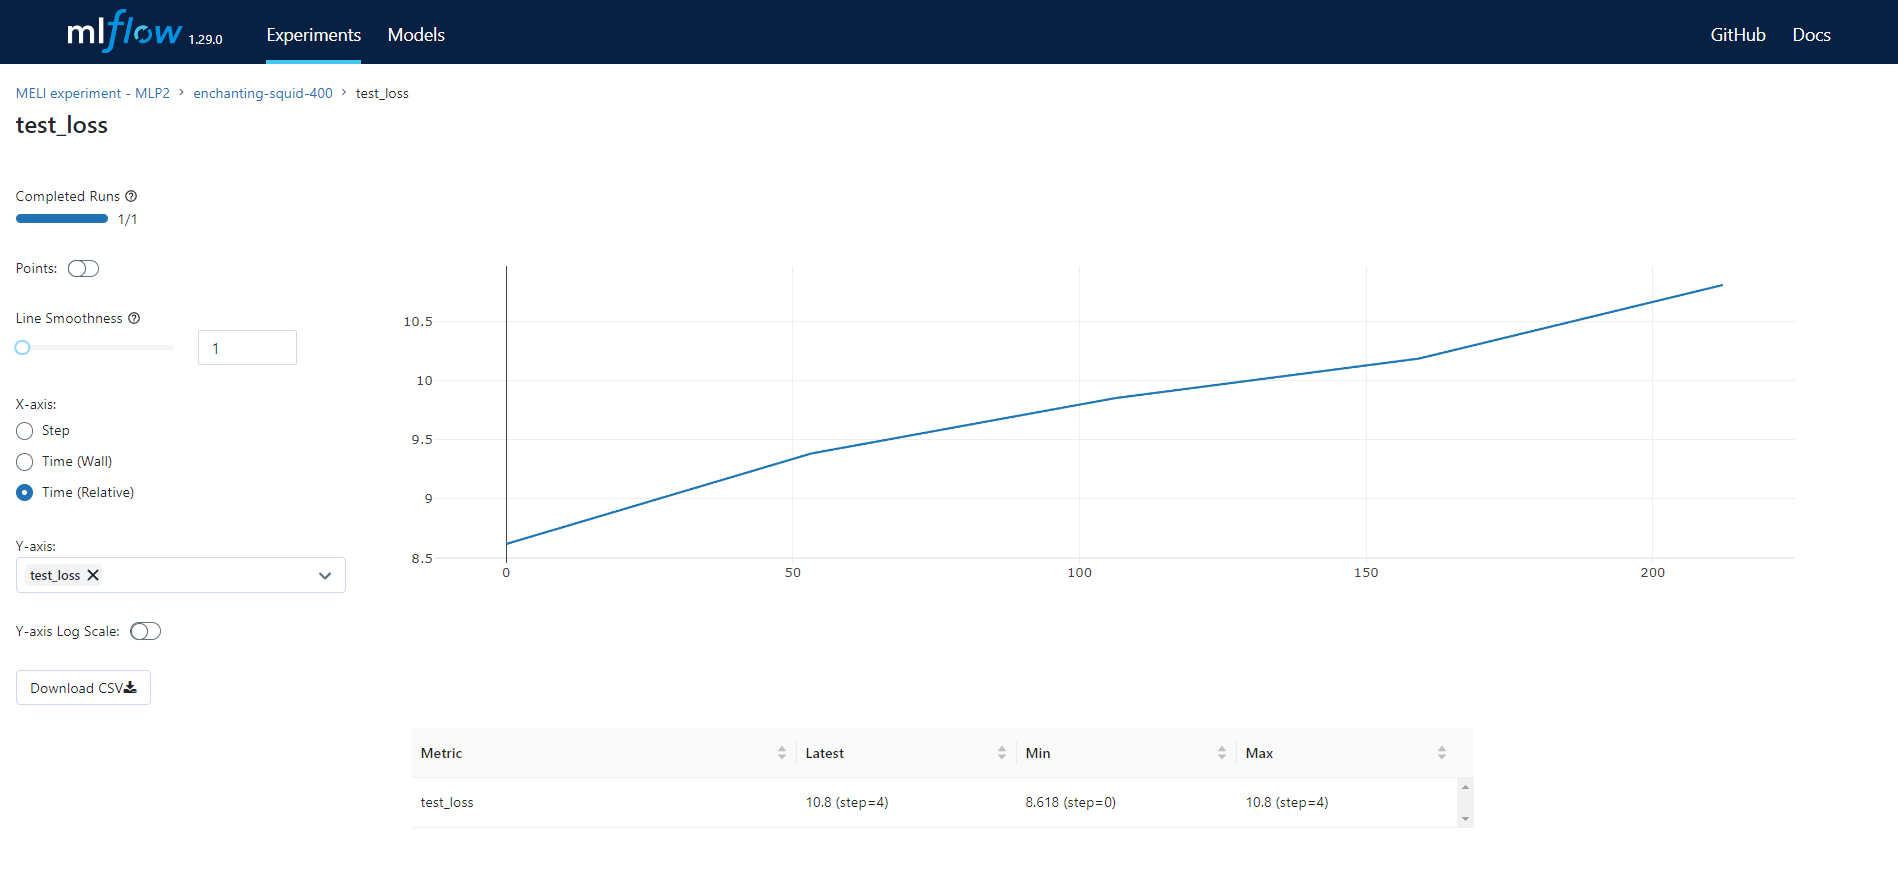

### MLP3

#### Balanced Accuracy

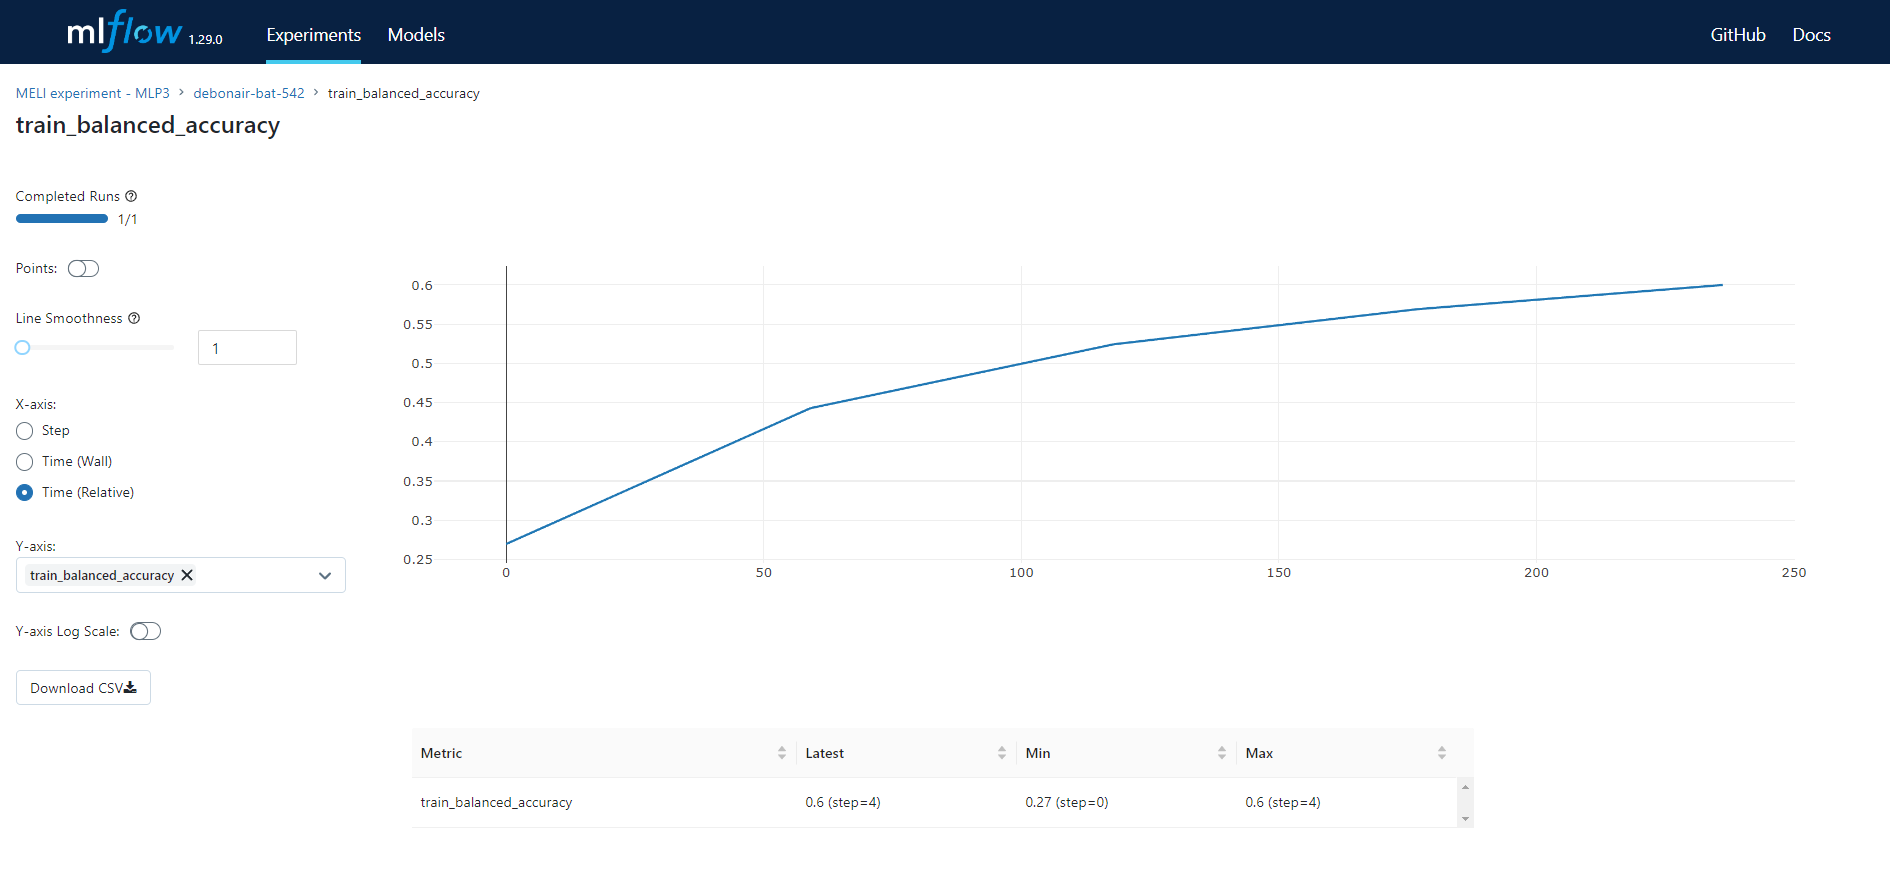

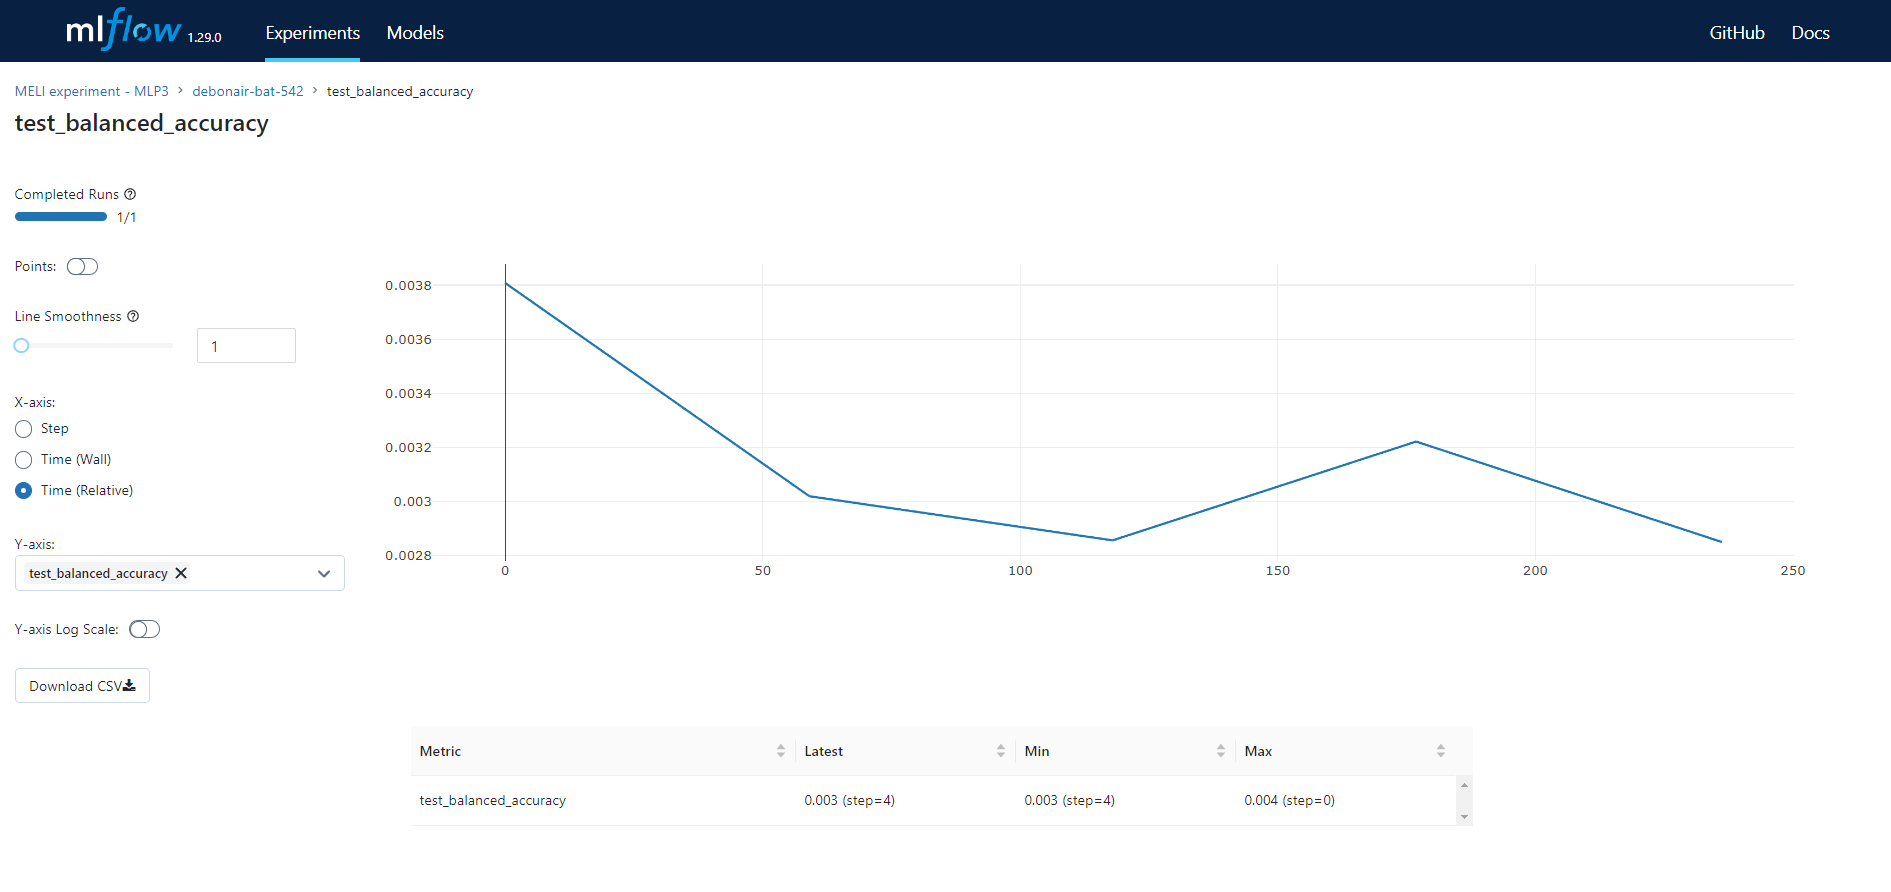

#### Loss

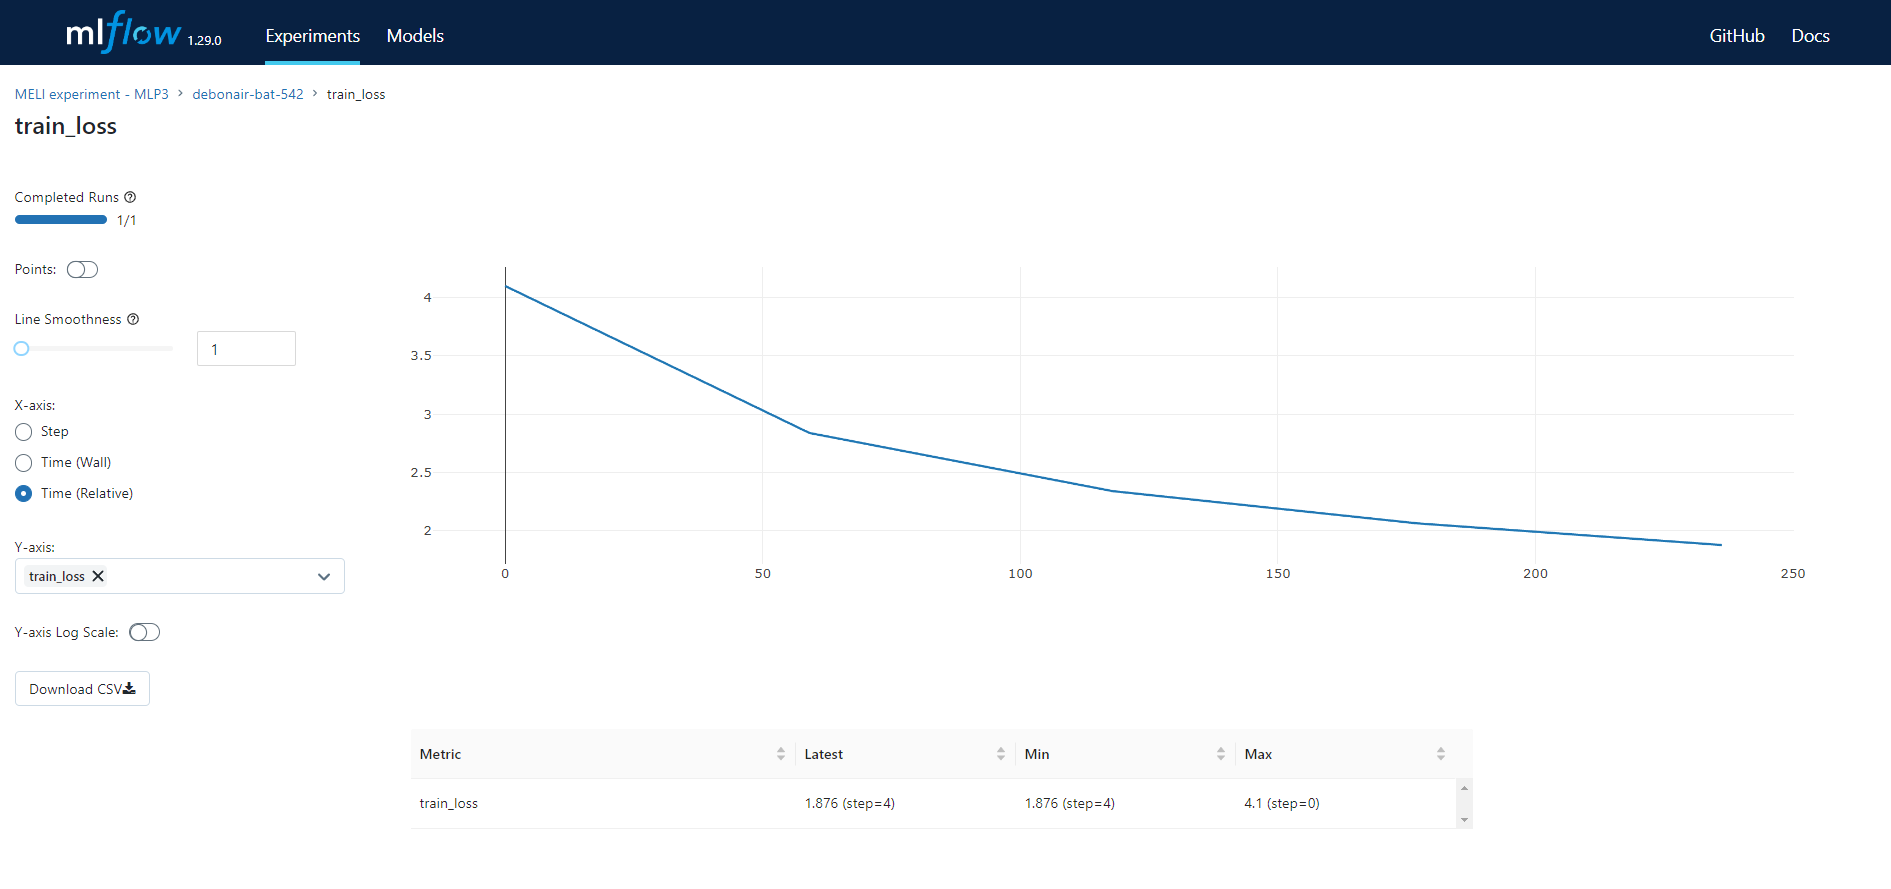

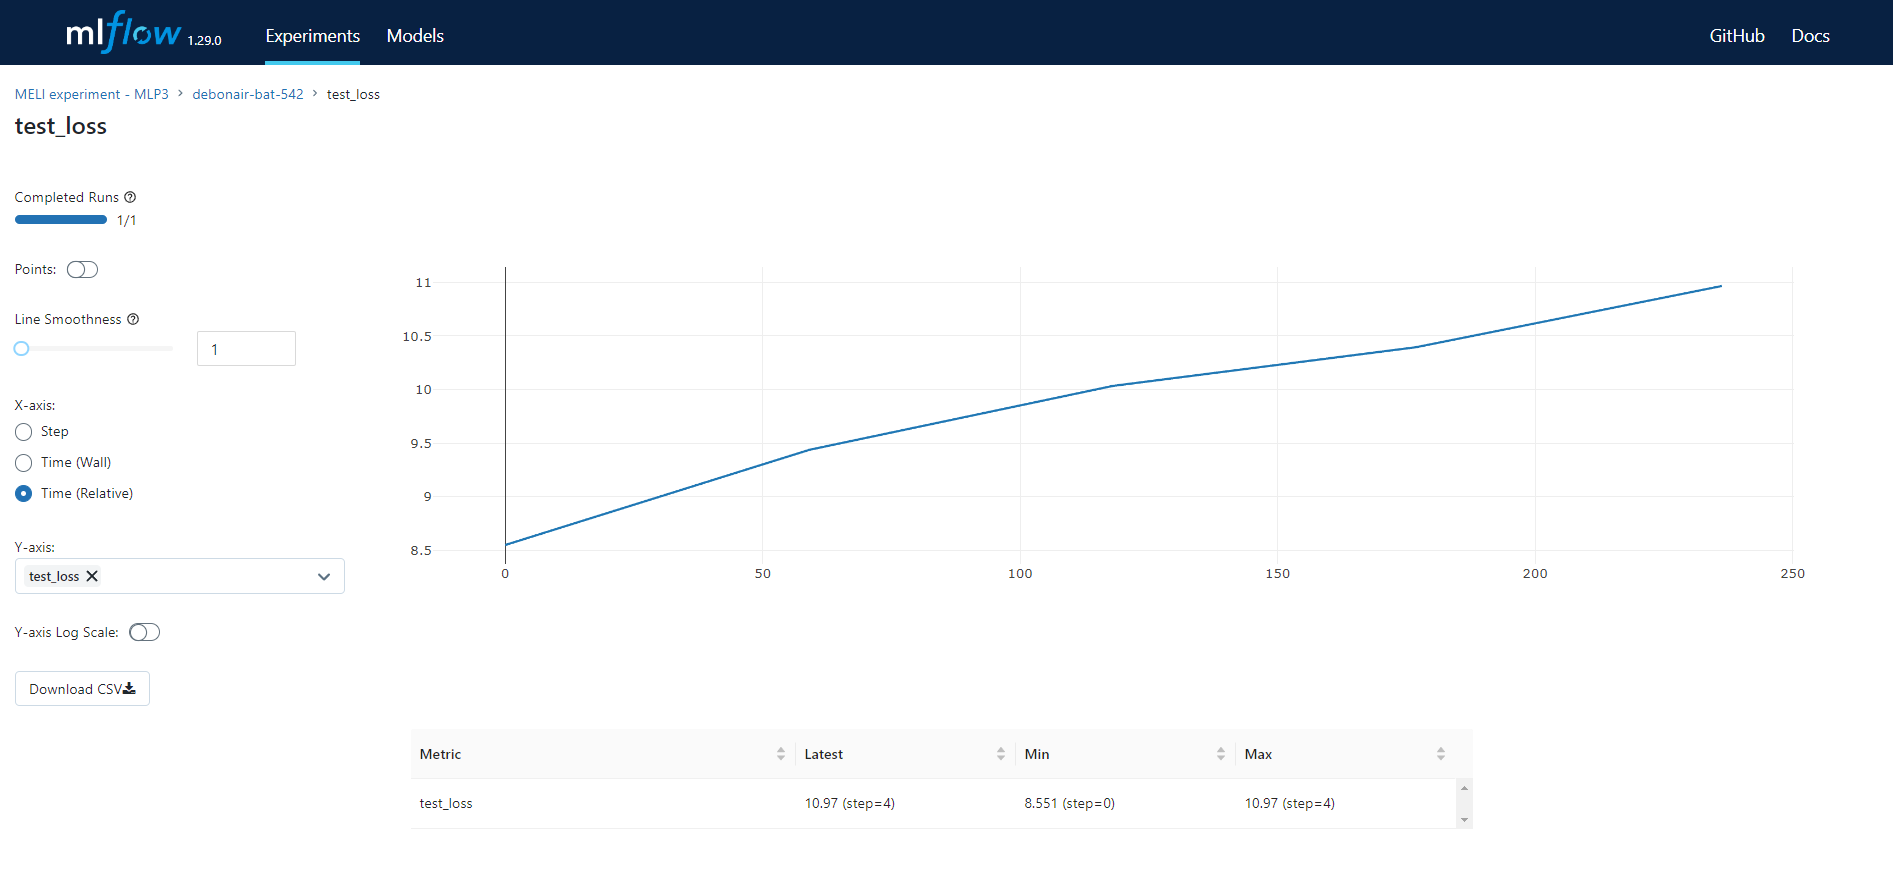

### MLP4

#### Balanced Accuracy

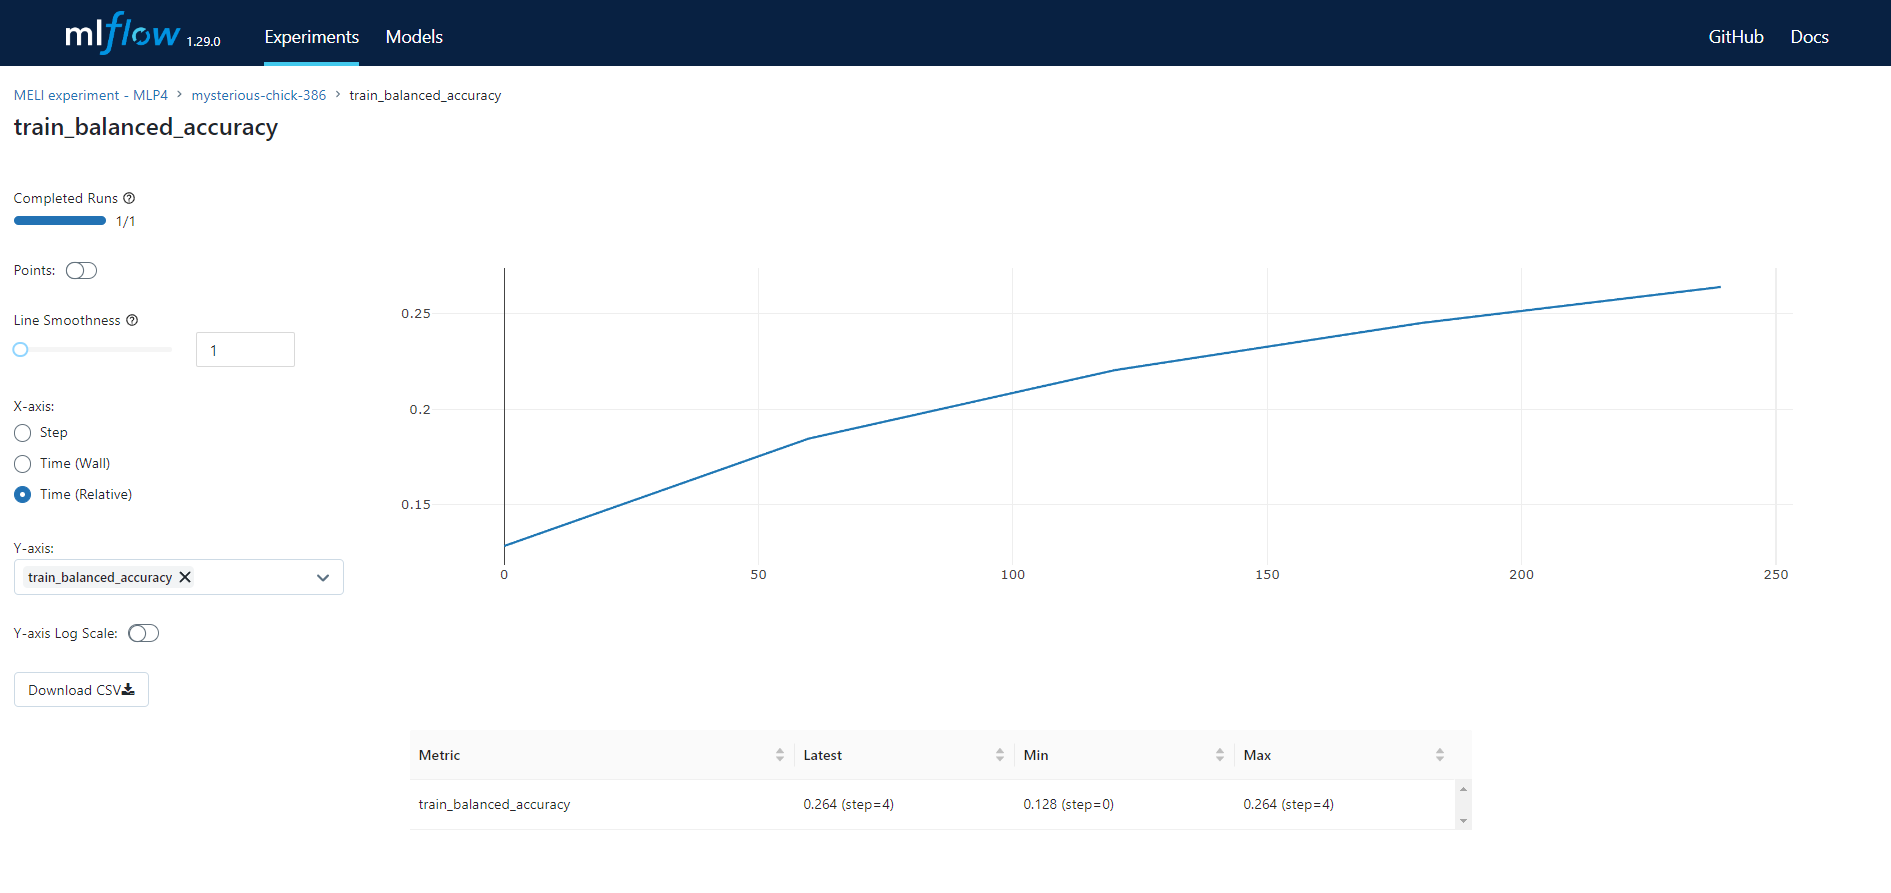

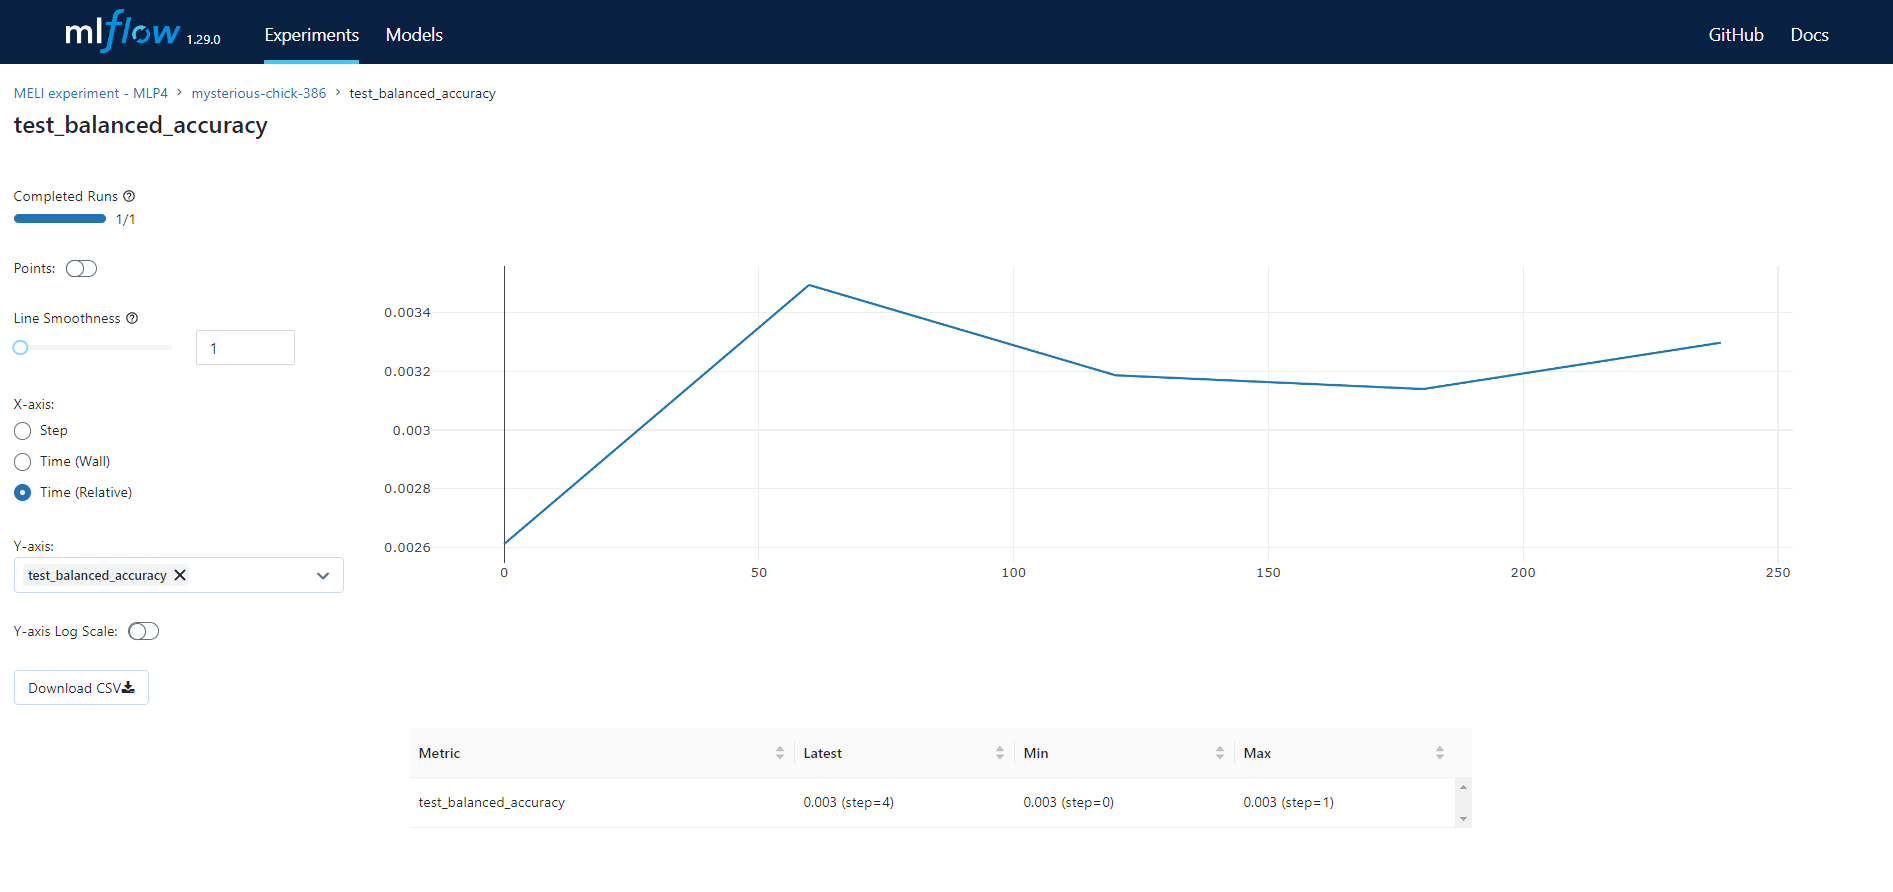

#### Loss

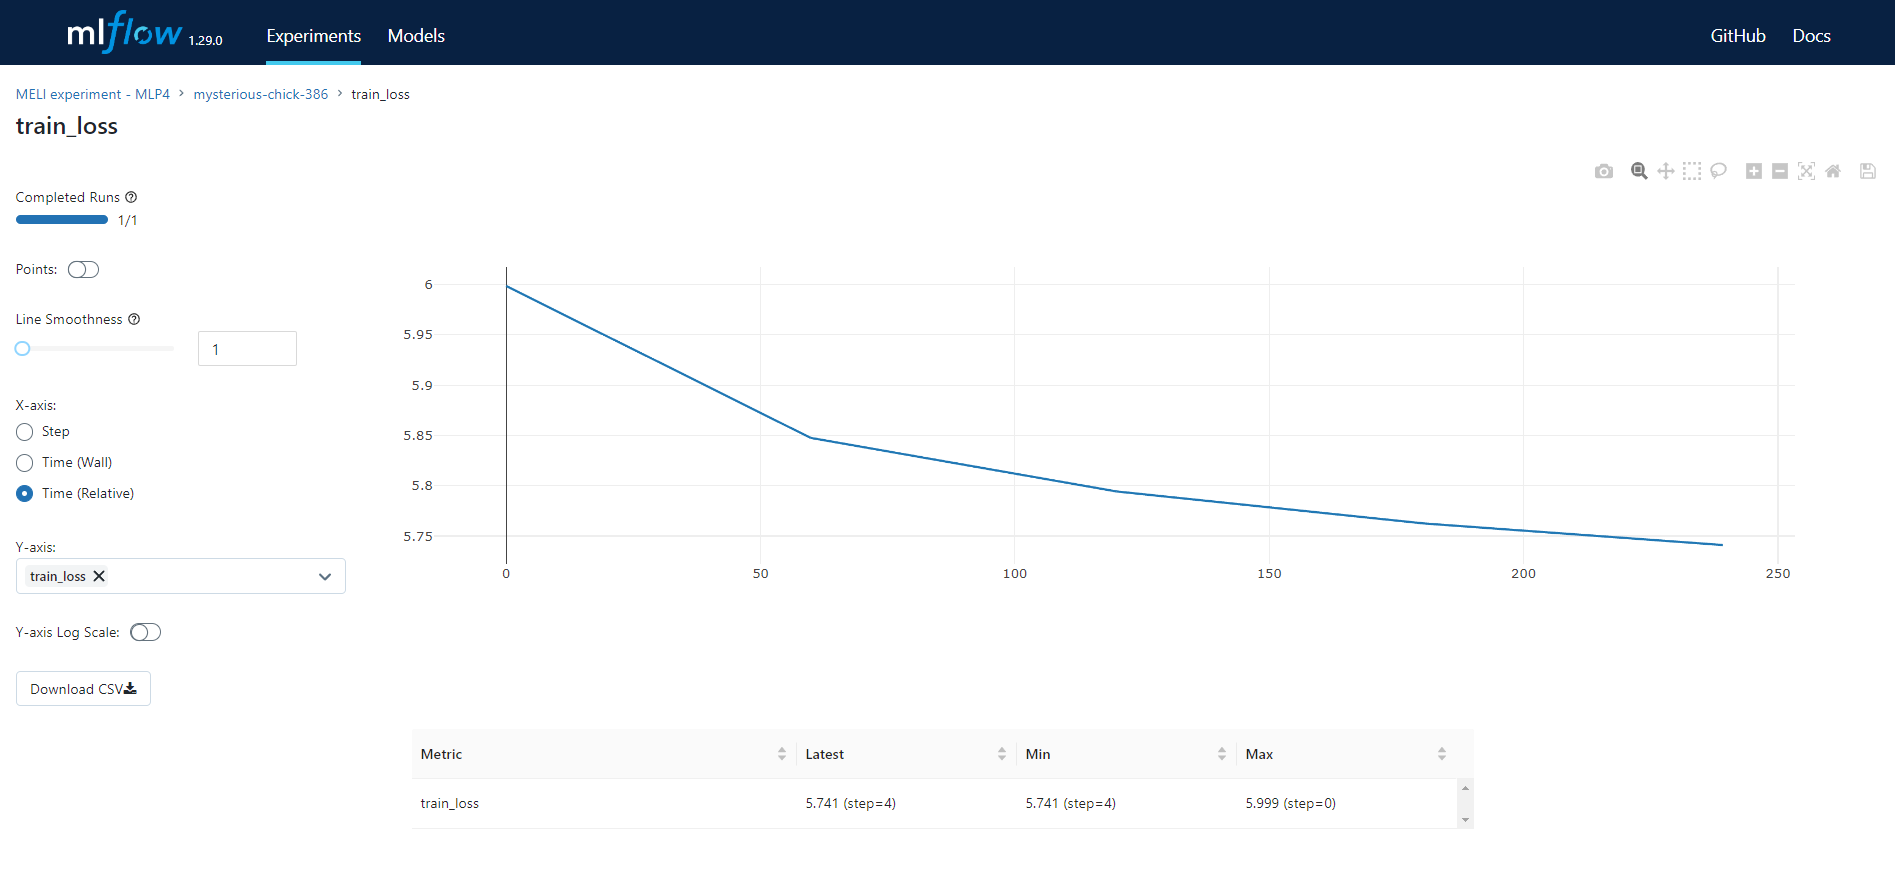

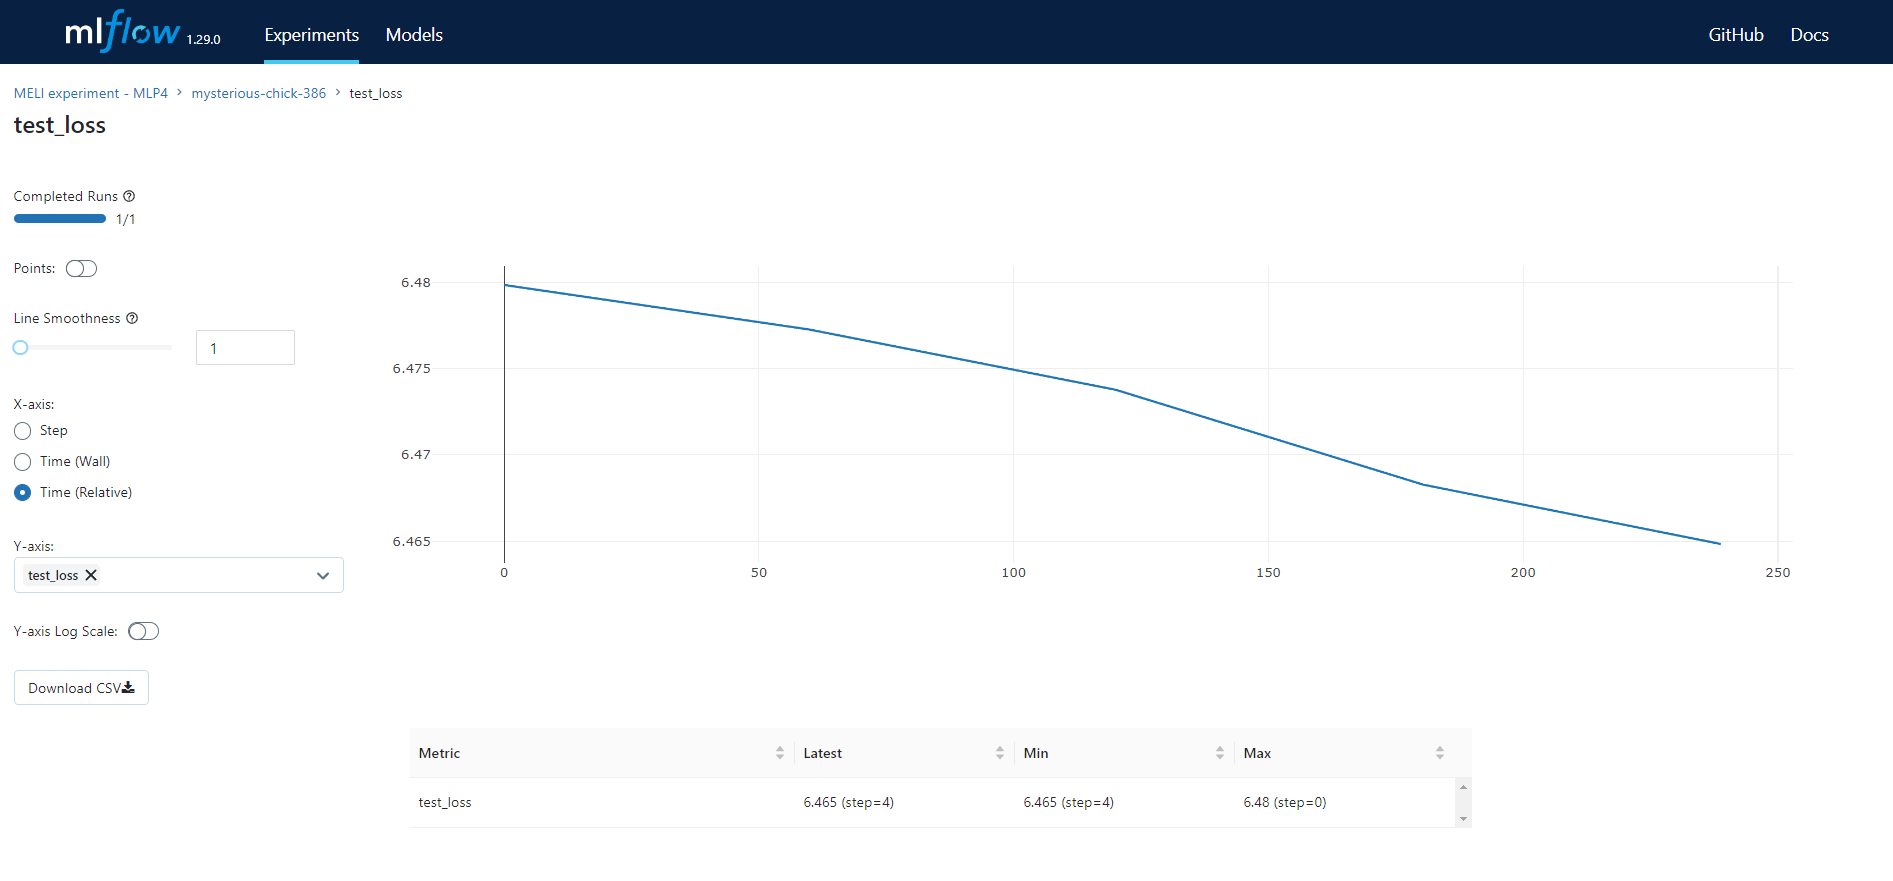

### MLP5

#### Balanced Accuracy

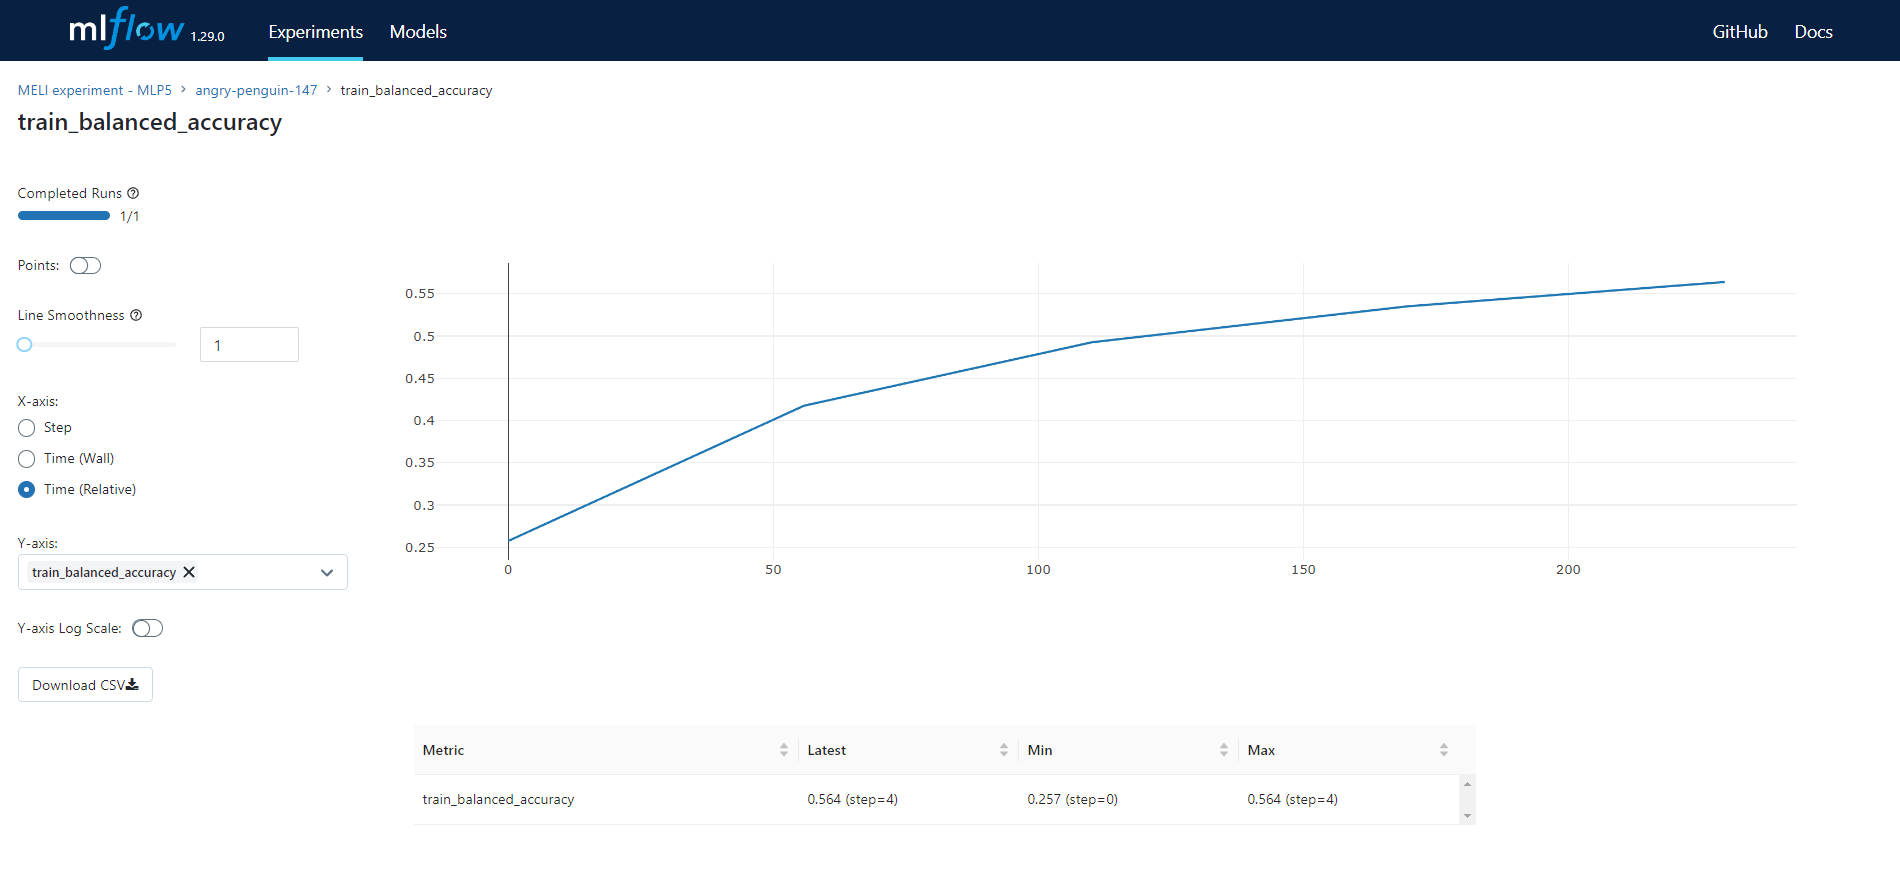

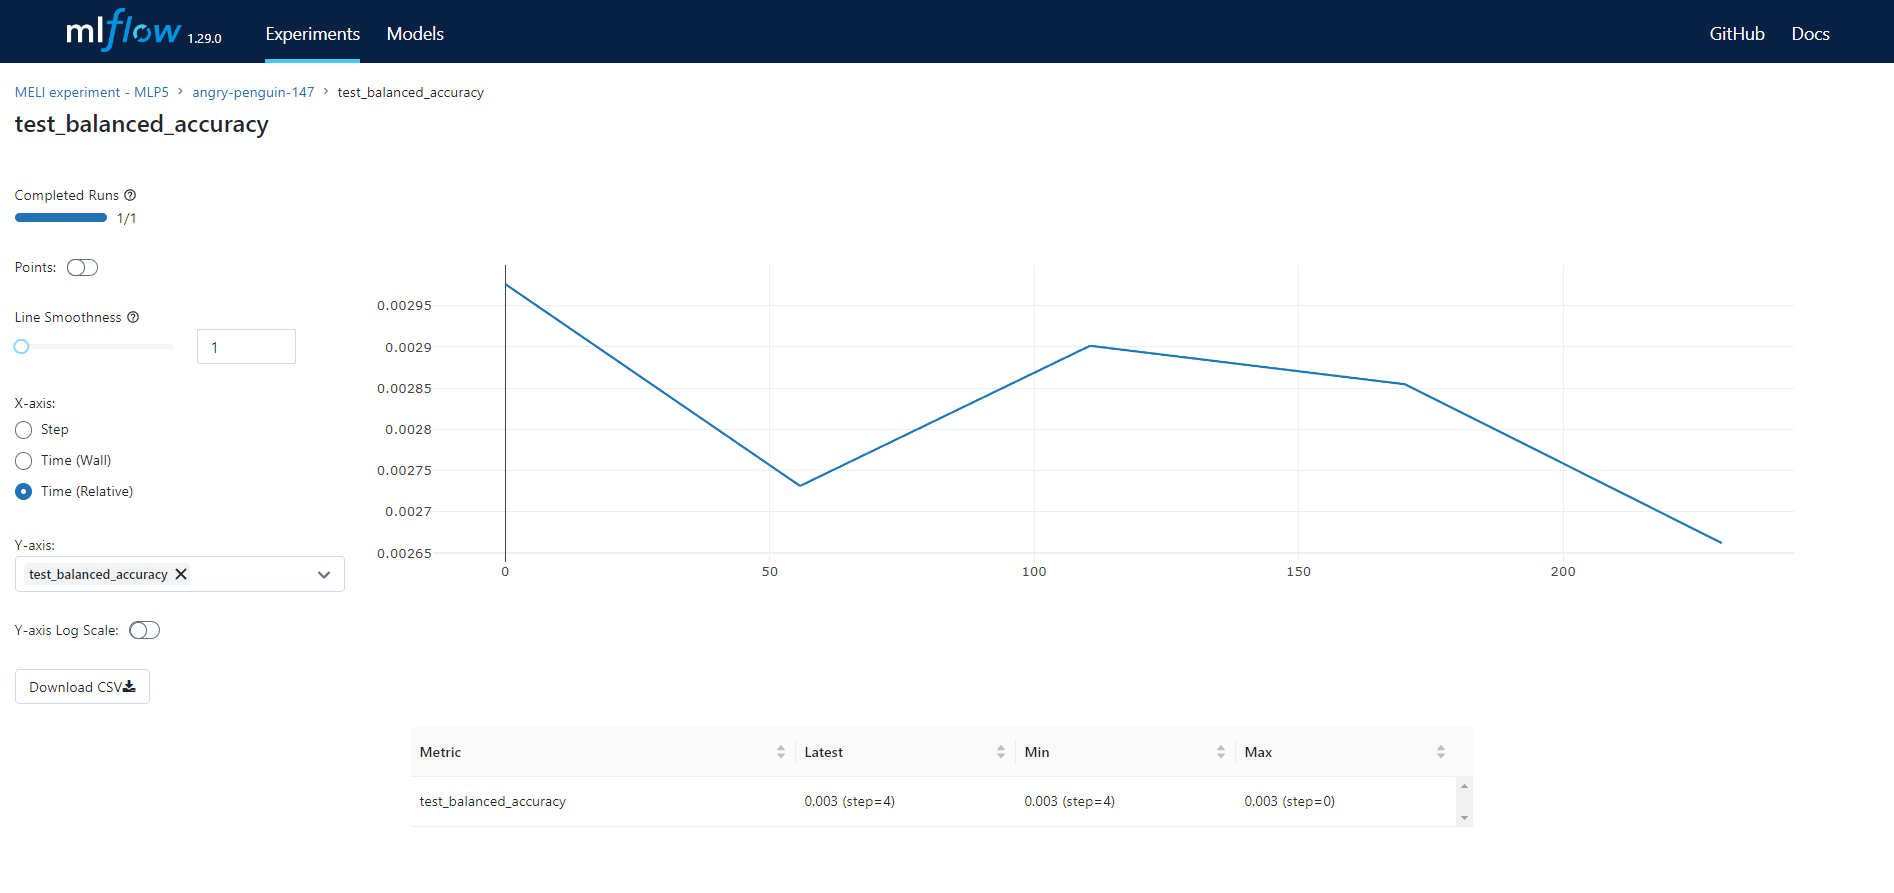

#### Loss

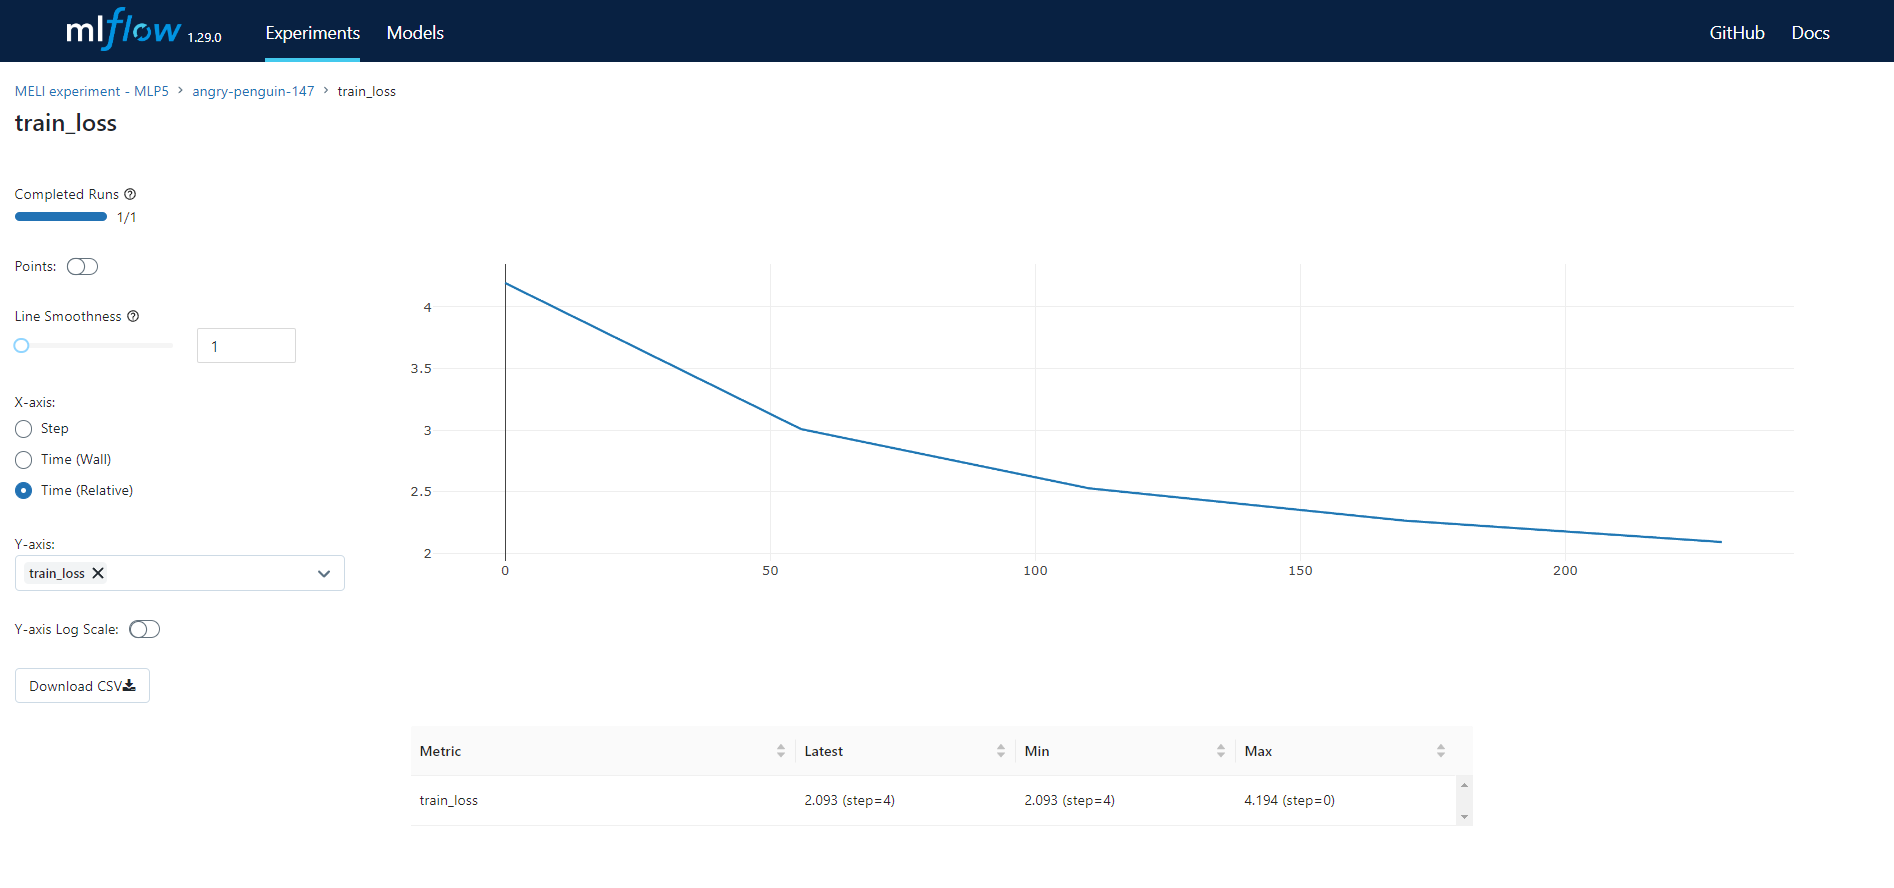

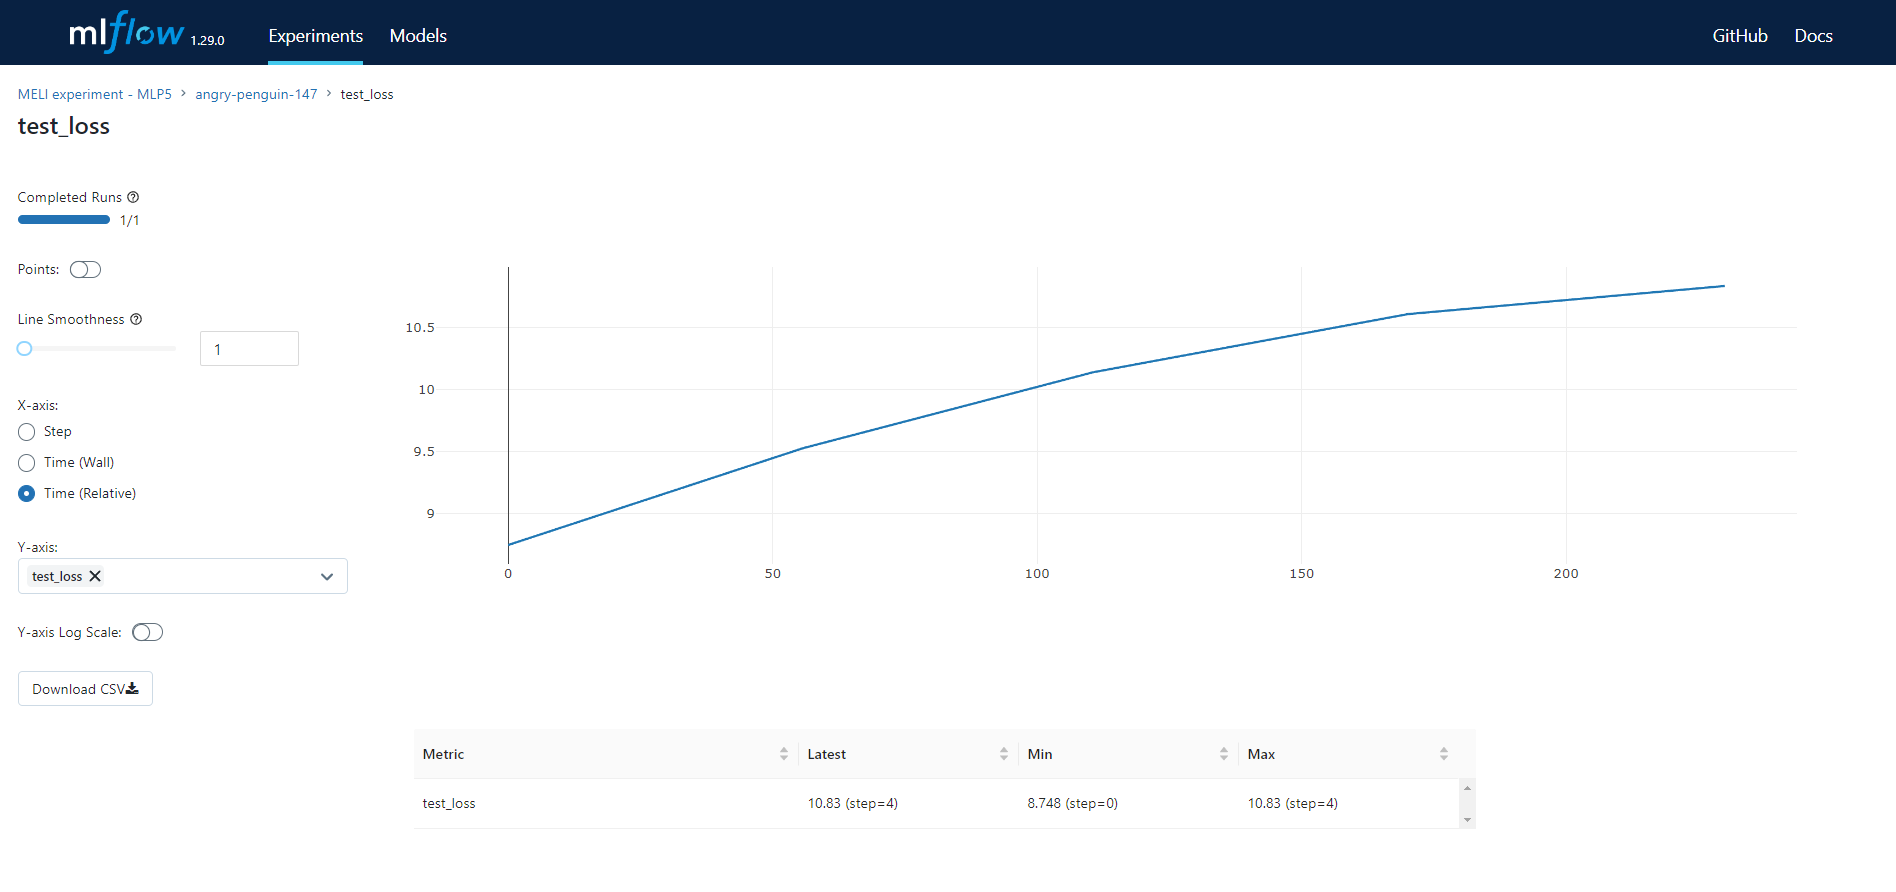

### MLP6

#### Balanced Accuracy

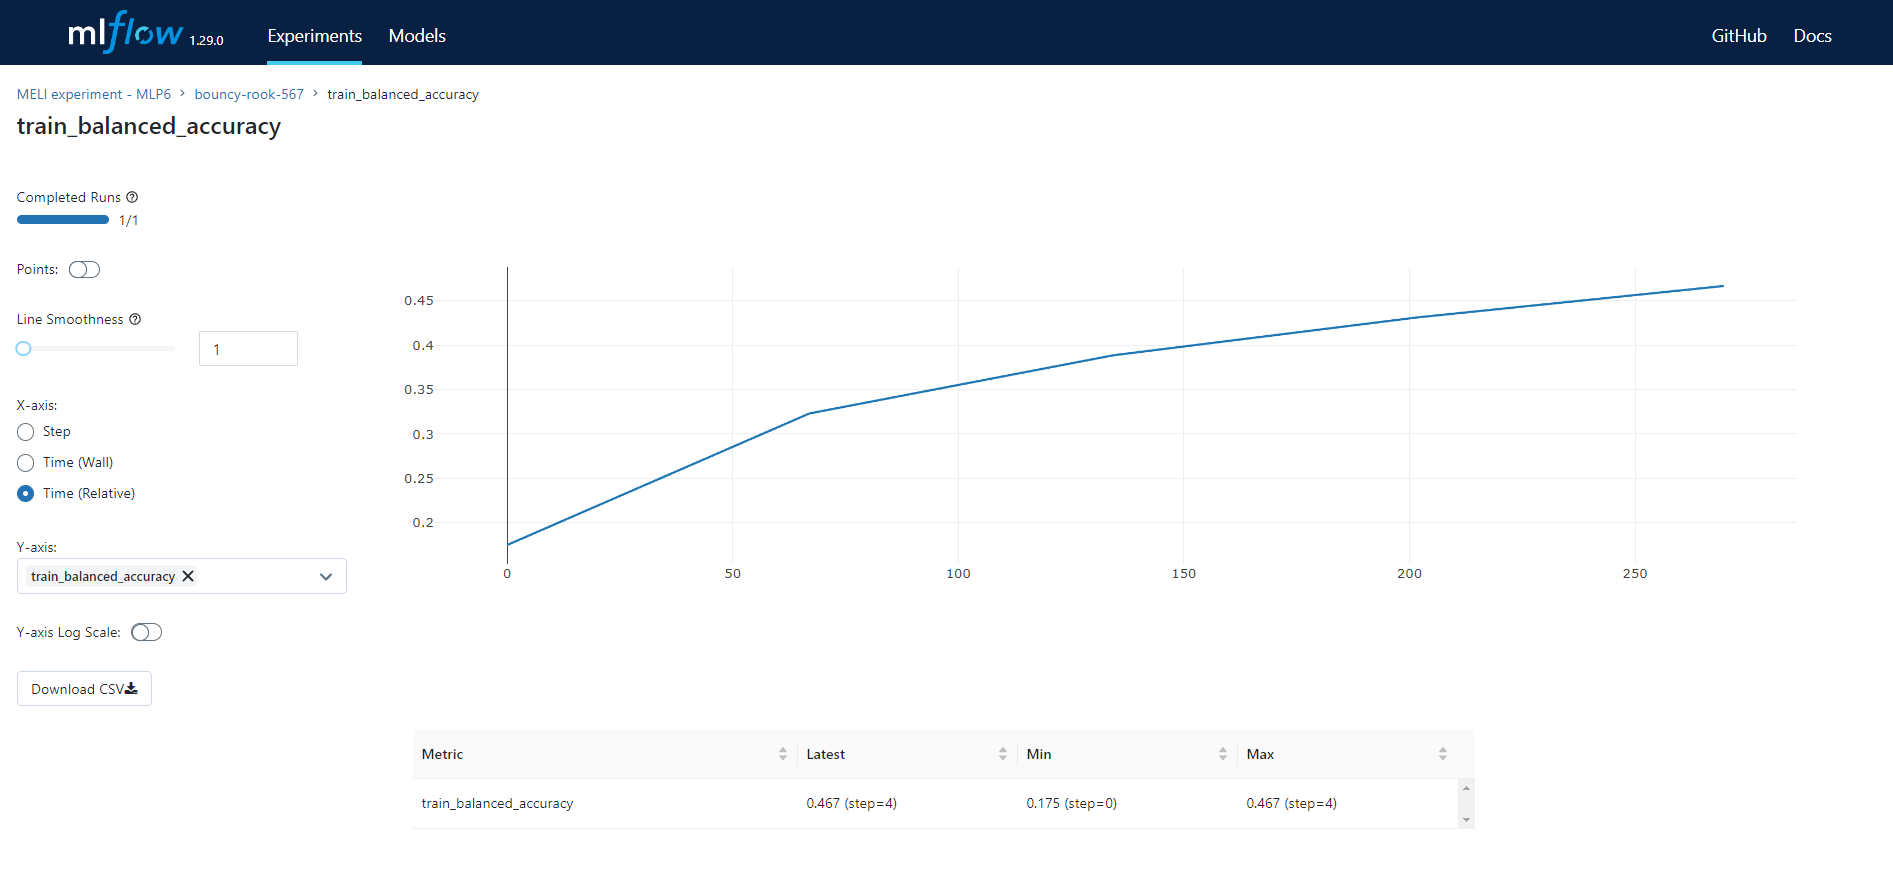

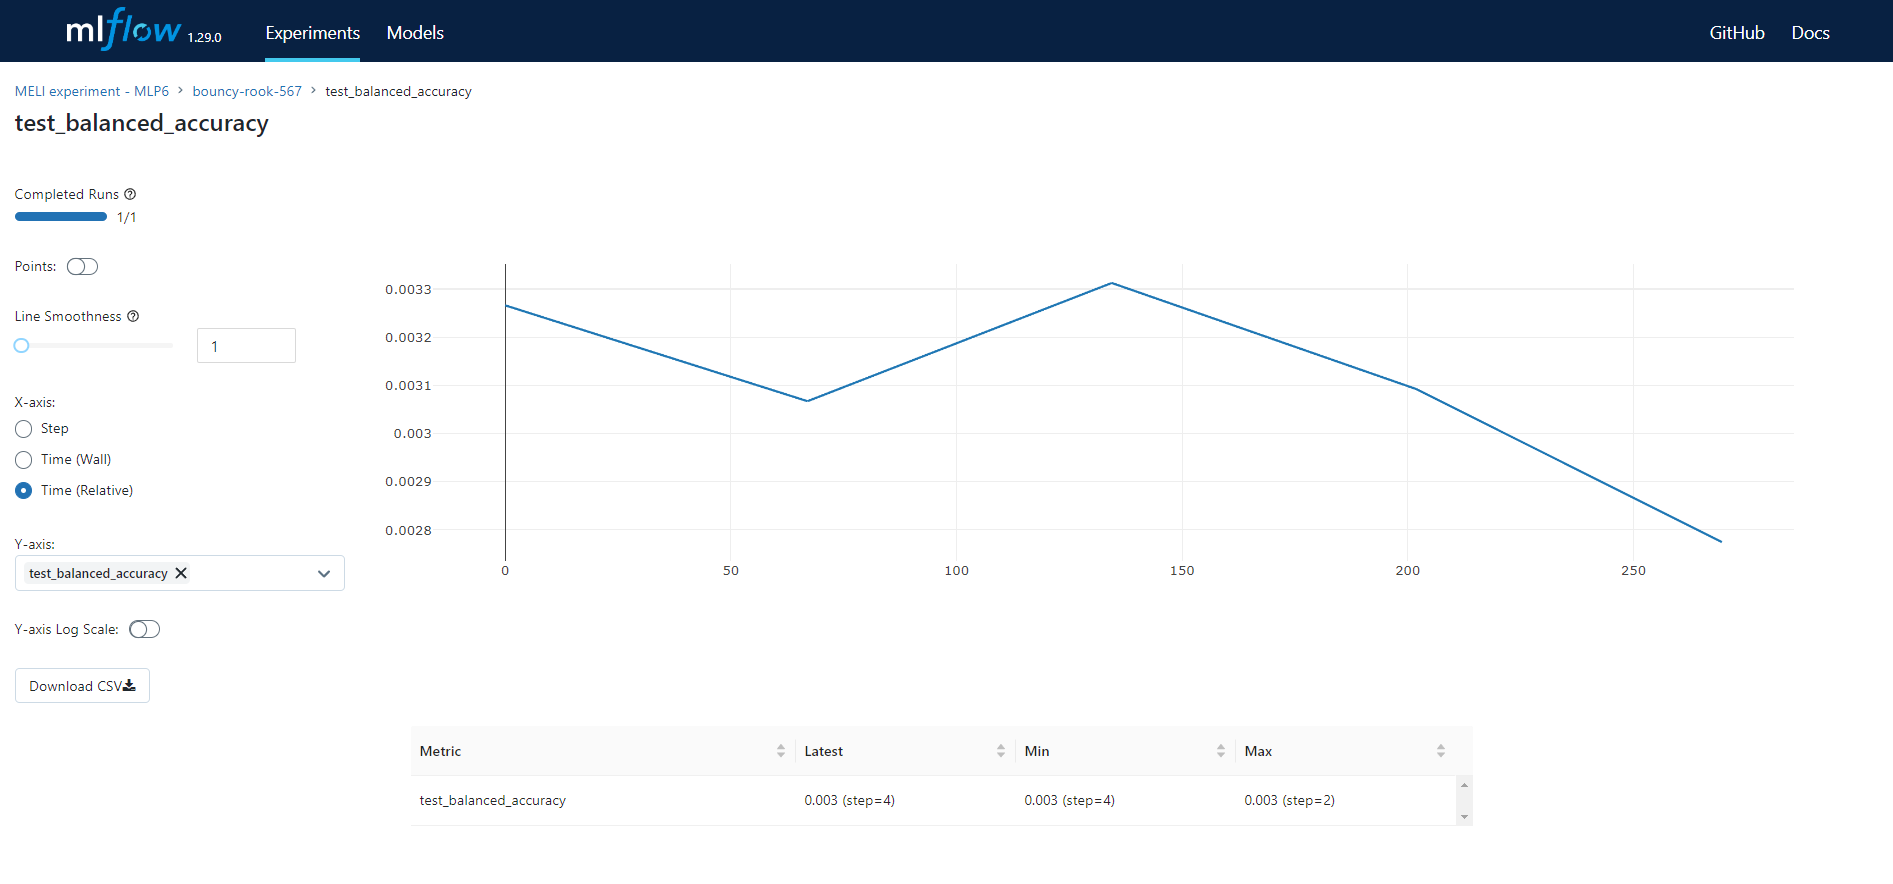

#### Loss

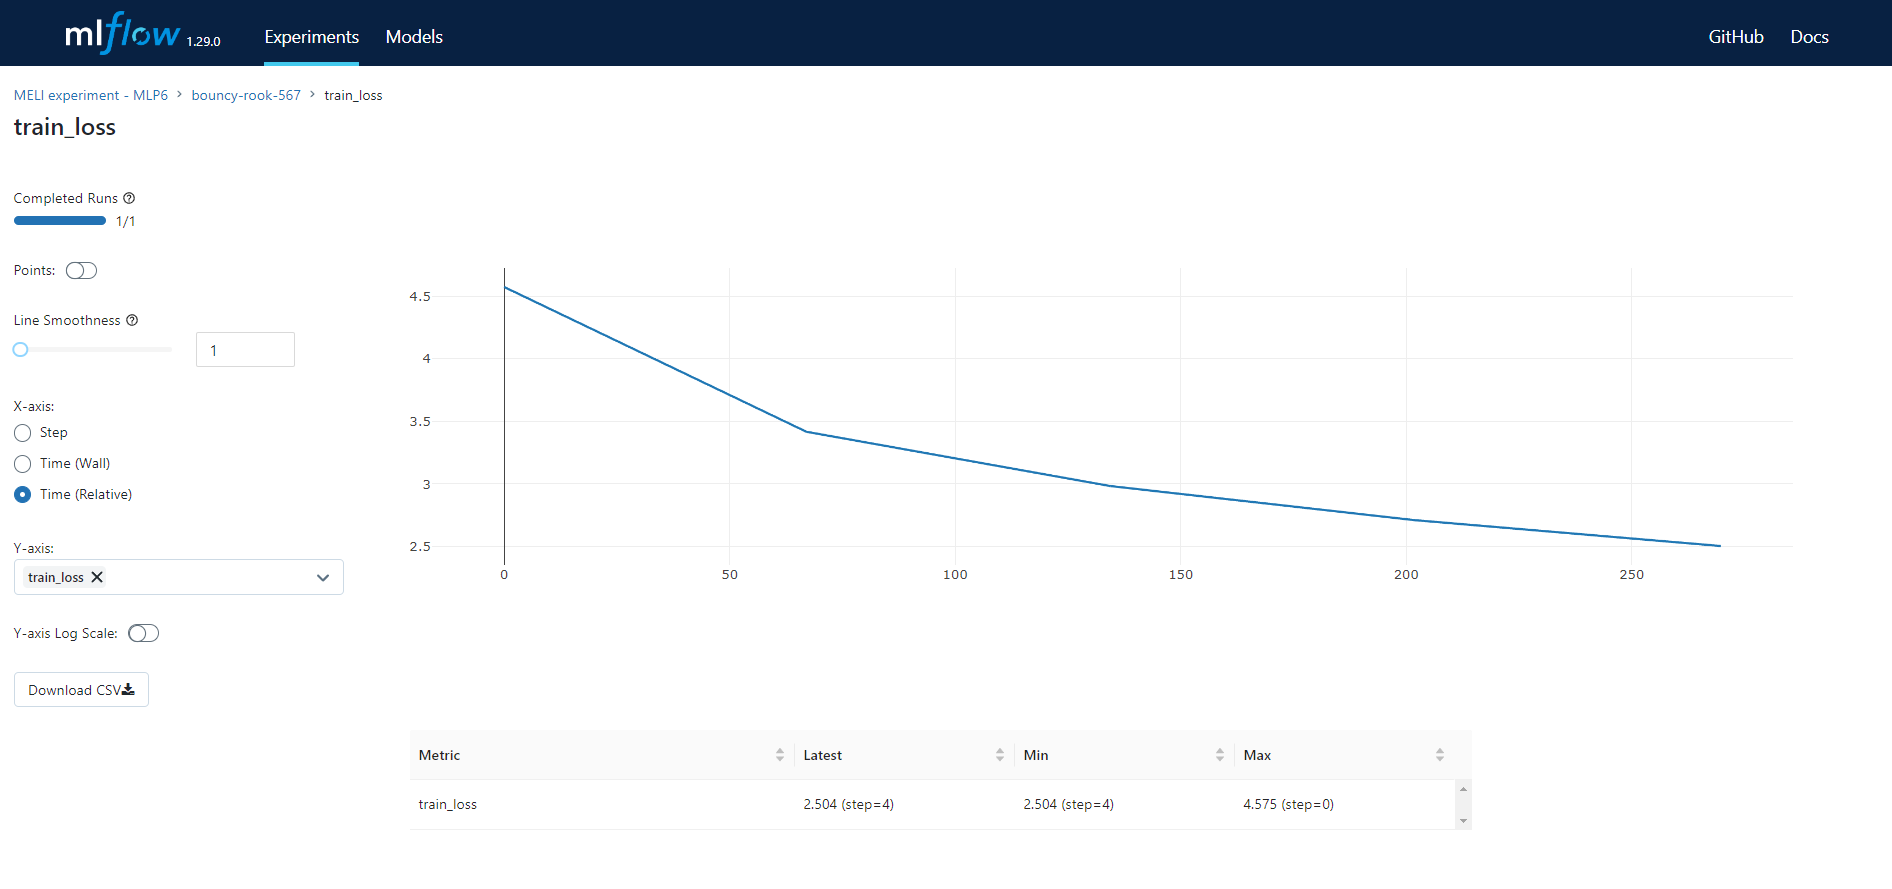

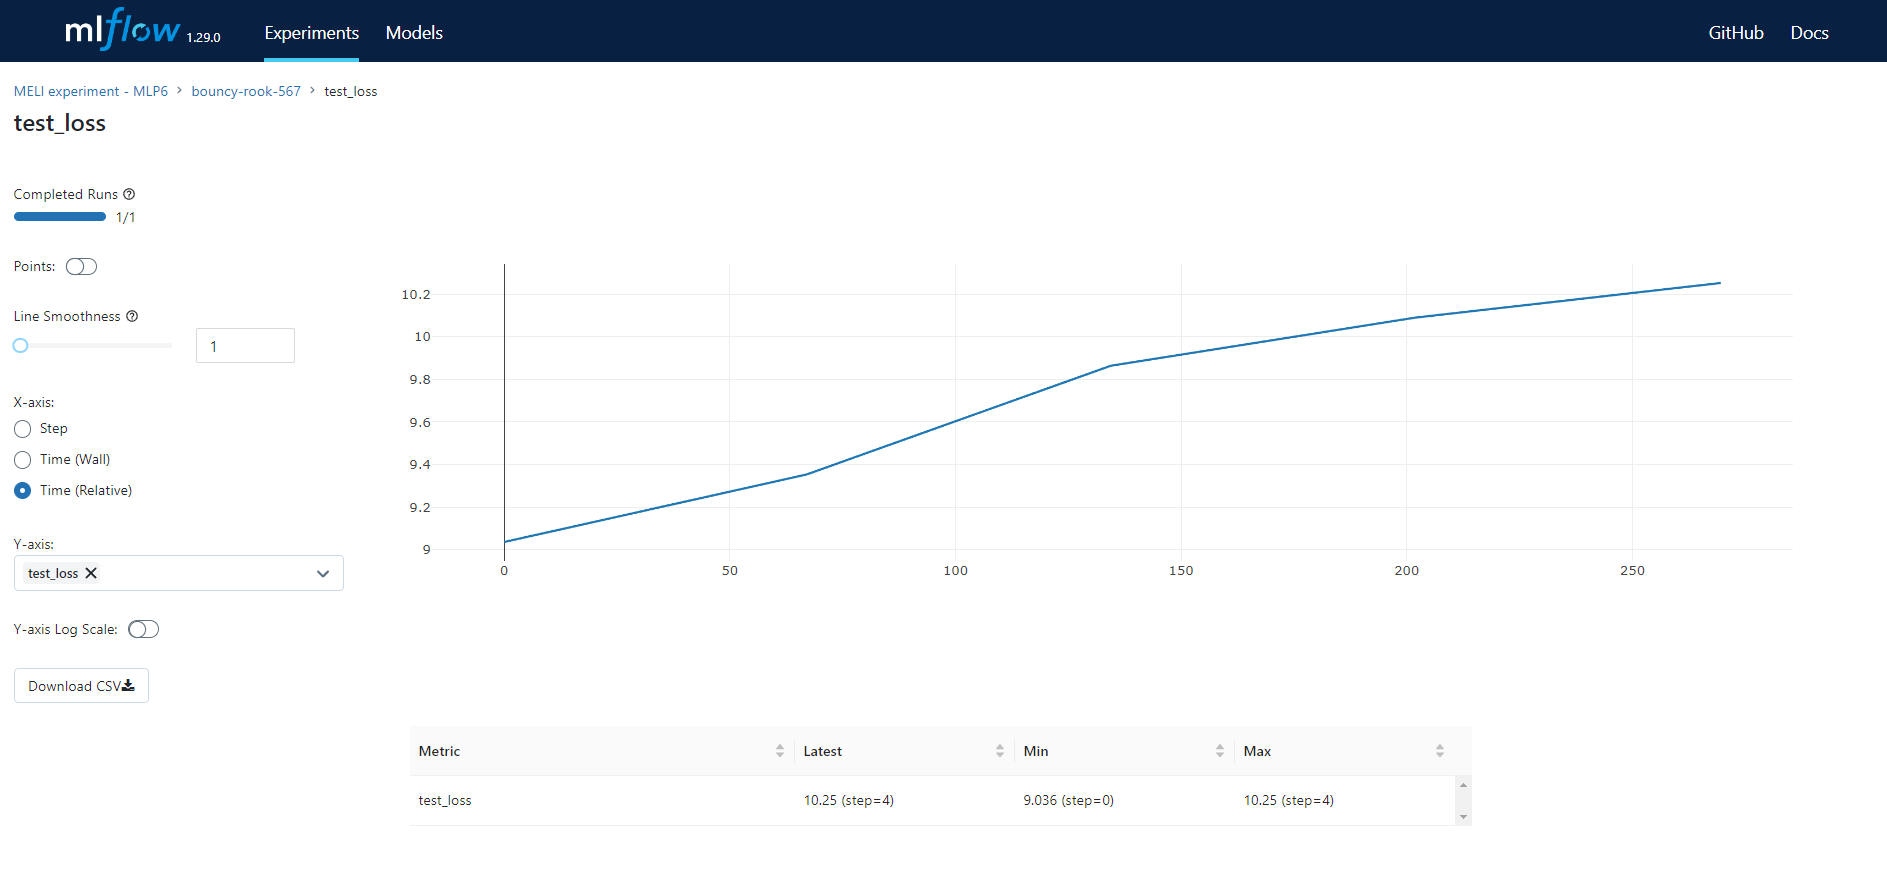

## Modelos Convolucionales

Definimos la clase para modelar este tipo de redes

In [ ]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, 
                 vector_size,
                 embedings,
                 filters_length,
                 filters_count,
                 layers,
                 name
                ):
        super().__init__()
        
        self.name = name
        self.filters_count = filters_count
        self.filters_length = filters_length
        
        self.embeddings = embedings
        
        self.convs = []
        for filter_lenght in filters_length:
            self.convs.append(
                nn.Conv1d(vector_size, filters_count, filter_lenght) 
                        #(in_channels, out_channels , kernel_size)
            )
        self.convs = nn.ModuleList(self.convs)
        
        self.layers = nn.ModuleList([layer.function for layer in layers])
        self.activations = [layer.activation for layer in layers]
        
        # self.fc = nn.Linear(filters_count * len(filters_length), 128)
        
        self.vector_size = vector_size
    
    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.activations[i](x)
            
        return x
    
    
    def layers_info(self):
        layers_info = {}
        layers_info["embedding_size"] = self.vector_size 
        layers_info["filters_count"] = self.filters_count,
        layers_info["filters_length"] = self.filters_length,
        for i, layer in enumerate(self.layers):
            layers_info[f"layer_{i+1}_input"] = layer.in_features 
            layers_info[f"layer_{i+1}_output"] = layer.out_features 
        return layers_info
    
    
class PadSequences:
    def __init__(self, 
                 pad_value=0, 
                 max_length=None, 
                 min_length=1):
        
        assert max_length is None or min_length <= max_length #Sanity check
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            # Si no tenemos max_lenght definido, tomamos el mínimo entre min_lenght y
            # la longitud de la máxima secuencia
            max_length = max(self.min_length, max(seq_lengths))
        
        
        # Para secuencias cuya longitud es menor que max_lenght rellenamos los valores
        # faltantes con 0 (pad_value)
        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
    
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [ ]:
filters_count = 100
filters_length = [2, 3, 4]

#Instanciamos las clases
pad_sequences = PadSequences(min_length=max(filters_length))

train_loader = DataLoader(meli_train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(meli_test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)

In [ ]:
convolutionalModel1 = ConvolutionalNeuralNetwork( 
    vector_size,
    embeddings_layer,
    filters_length,
    filters_count,
    [
        Layer(nn.Linear(filters_count * len(filters_length), 512), F.relu),
        Layer(nn.Linear(512, 632), nothing)
    ],
    "CNN1"
)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(convolutionalModel1.parameters(), lr=1e-3, weight_decay=1e-5)
run_experiment(convolutionalModel1, train_loader, test_loader, loss, optimizer, 3, device)

Traceback (most recent call last):
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 271, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 403, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1075, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1068, in _read_helper
    result = read_yaml(root, file_name)
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 181, in read_yaml


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

In [ ]:
convolutionalModel2 = ConvolutionalNeuralNetwork( 
    vector_size,
    embeddings_layer,
    filters_length,
    filters_count,
    [
        Layer(nn.Linear(filters_count * len(filters_length), 256), F.relu),
        Layer(nn.Linear(256, 632), nothing)
    ],
    "CNN2"
)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(convolutionalModel2.parameters(), lr=1e-3, weight_decay=1e-5)
run_experiment(convolutionalModel2, train_loader, test_loader, loss, optimizer, 3, device)

Traceback (most recent call last):
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 271, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 403, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1075, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1068, in _read_helper
    result = read_yaml(root, file_name)
  File "/users/jvelasco/miniconda3/envs/deeplearning/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 181, in read_yaml


  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/3907 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

## Métricas y reportes de modelos CNN

### CNN1

#### Balanced Accuracy

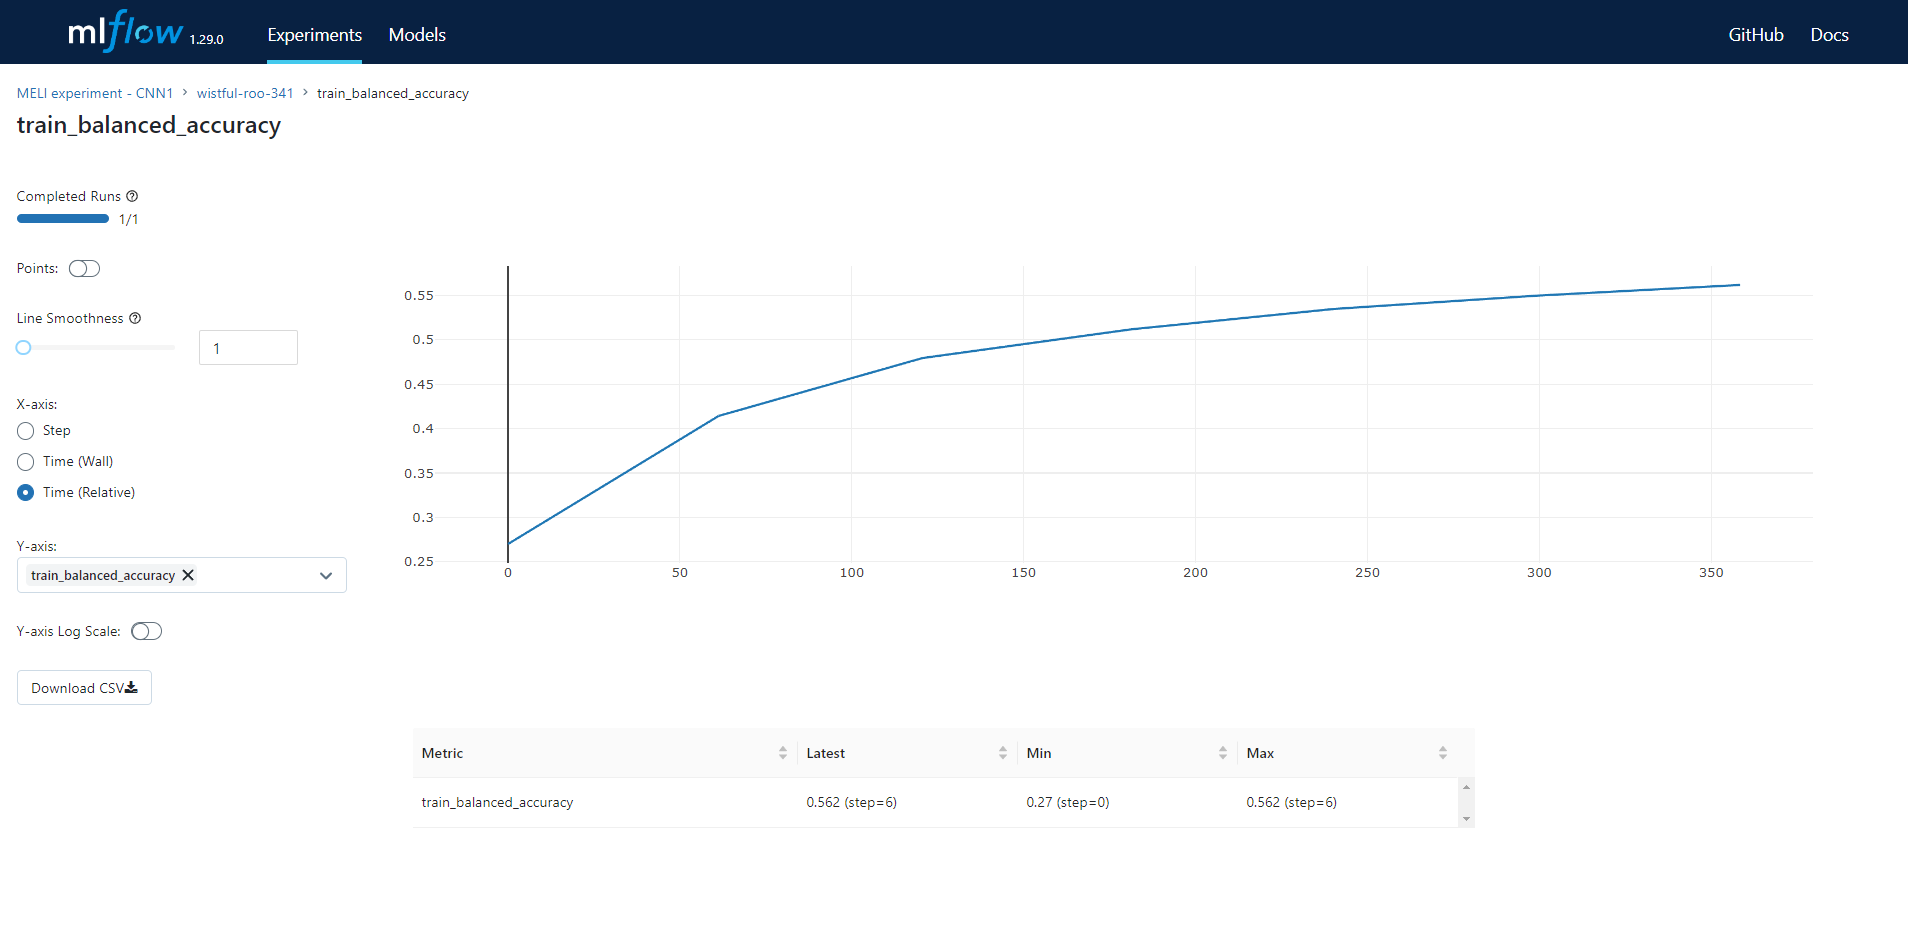

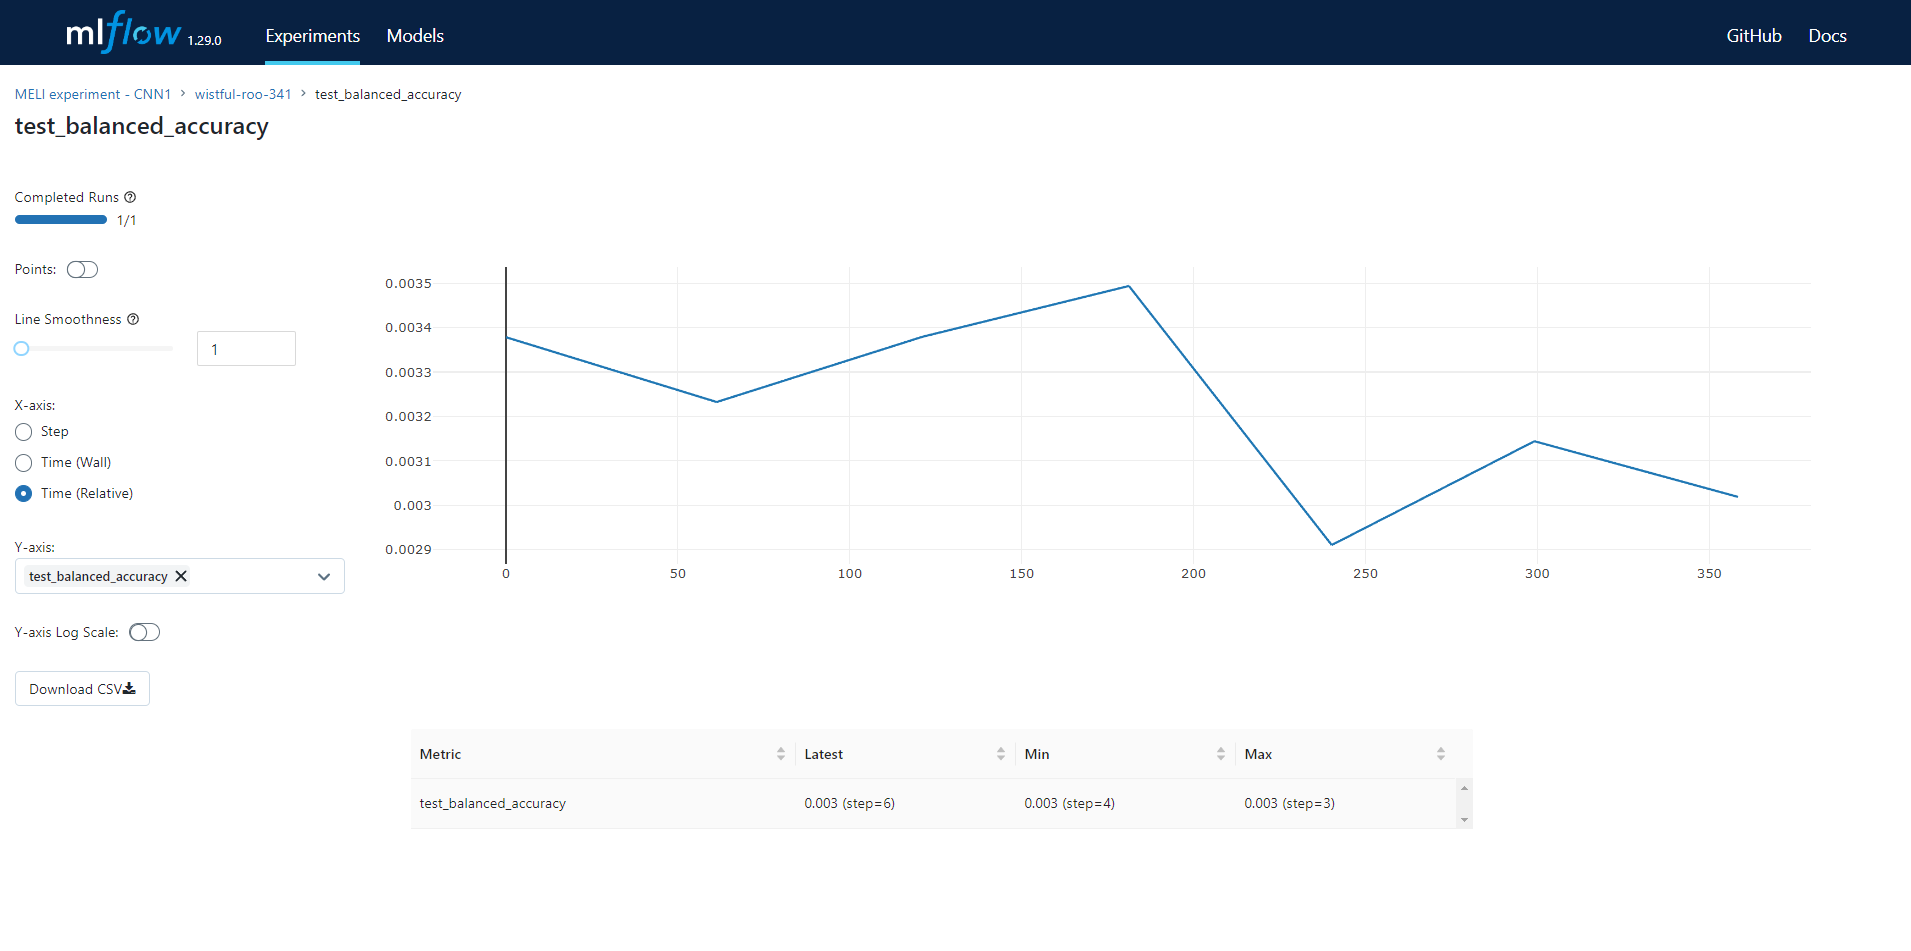

#### Loss

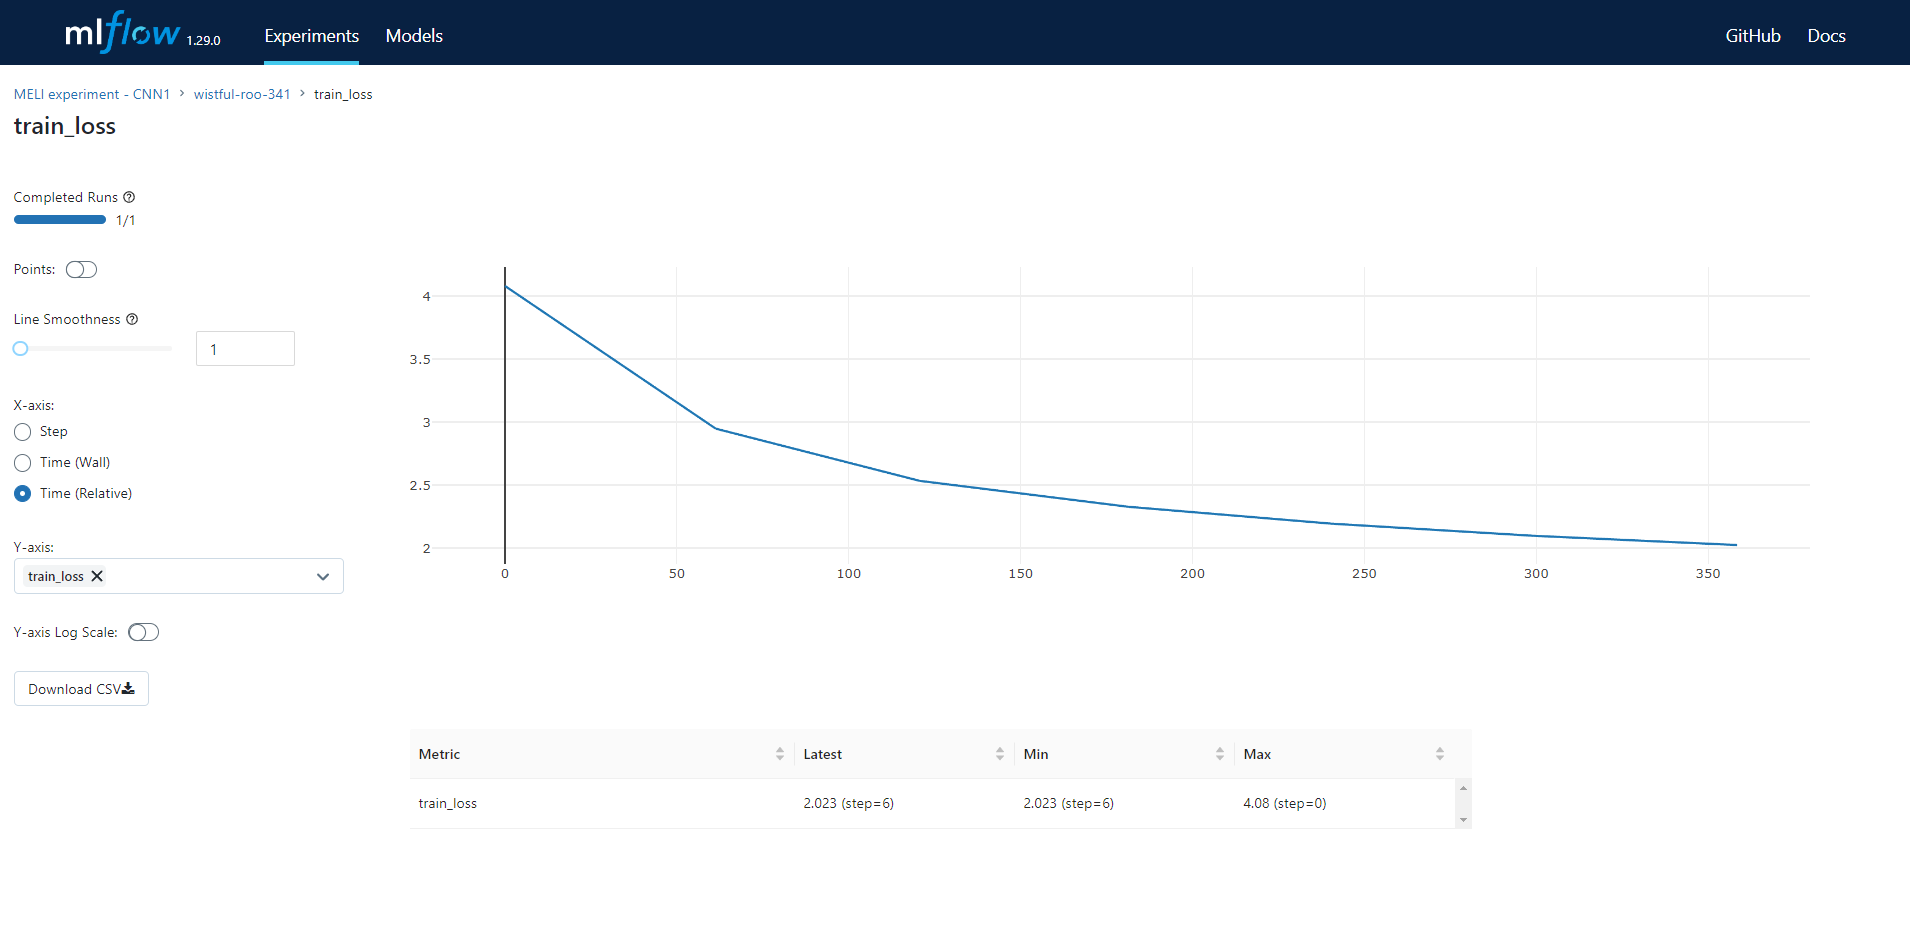

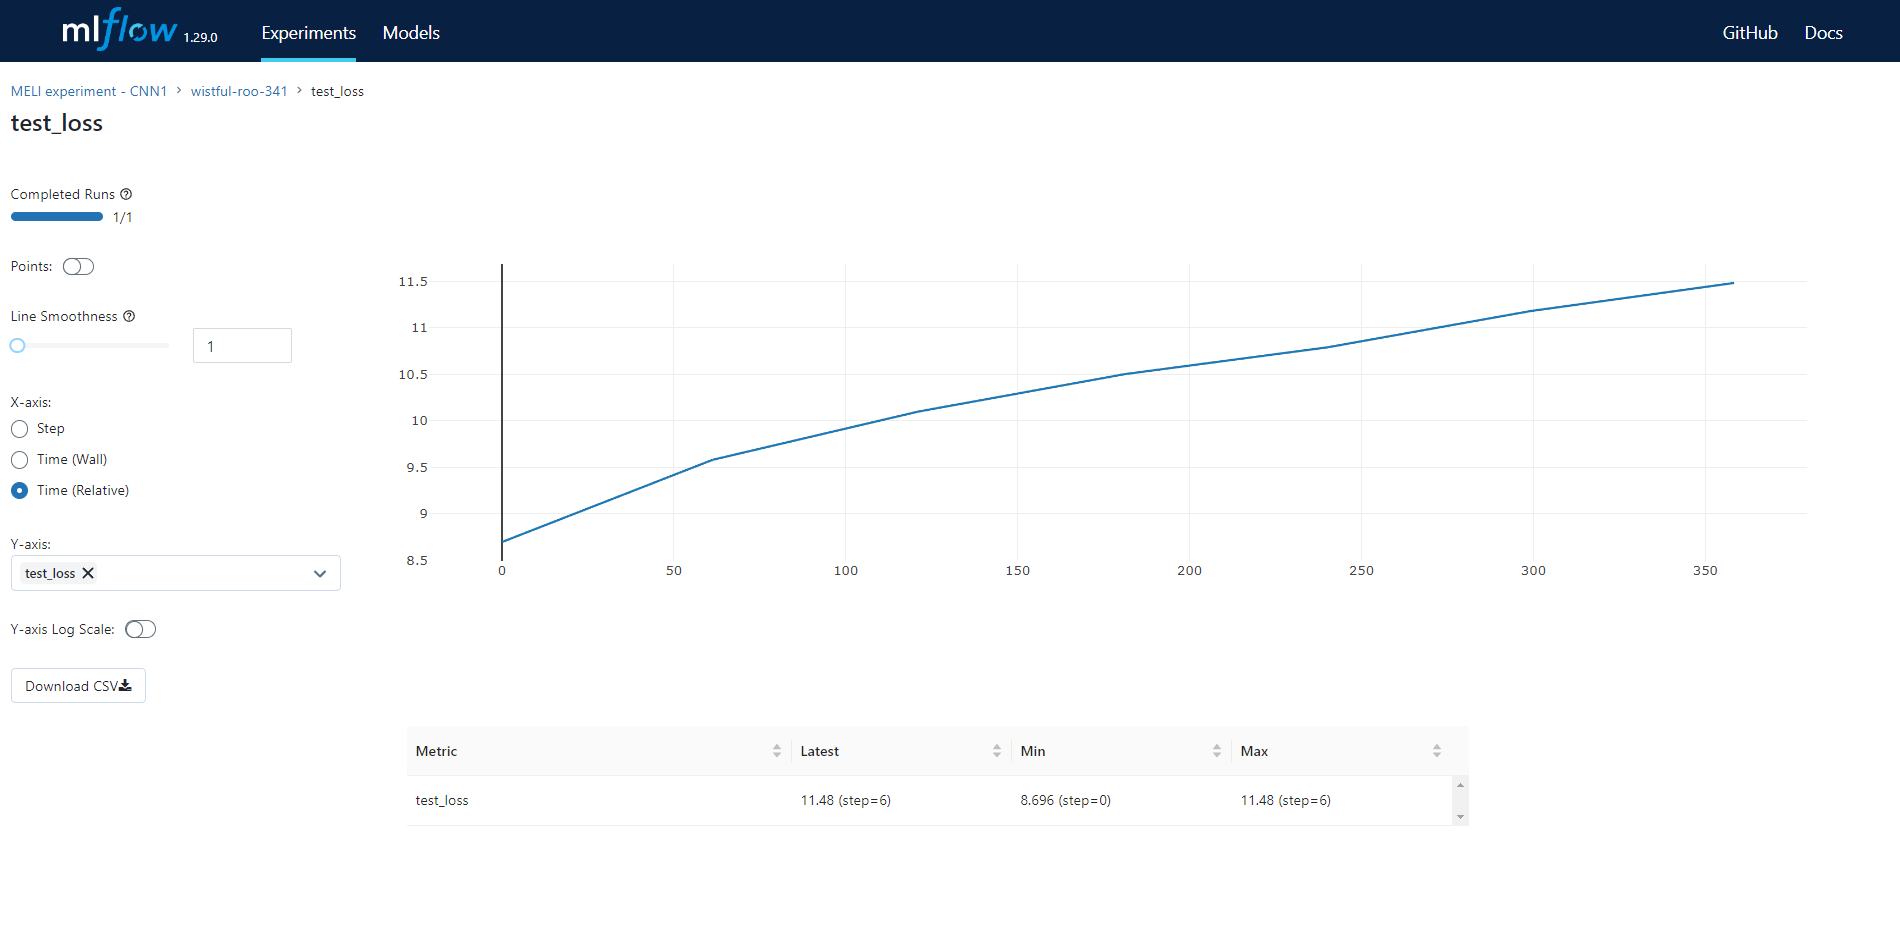

### CNN2

#### Balanced Accuracy

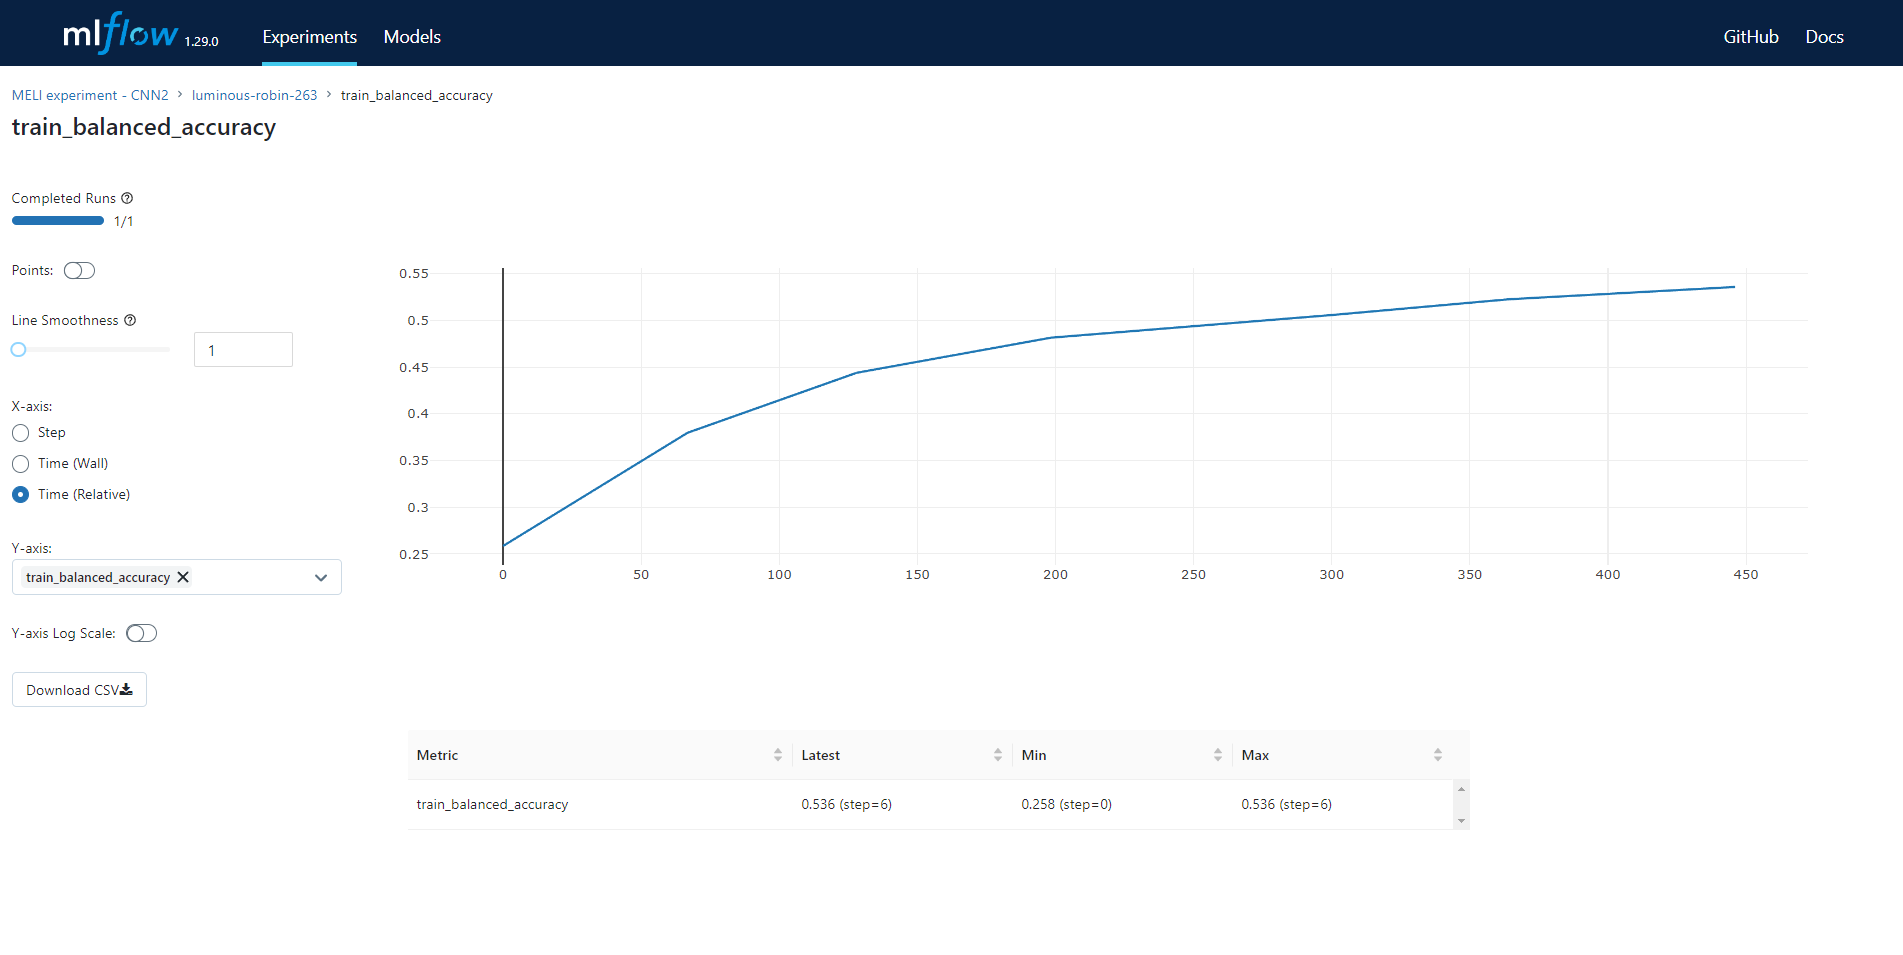

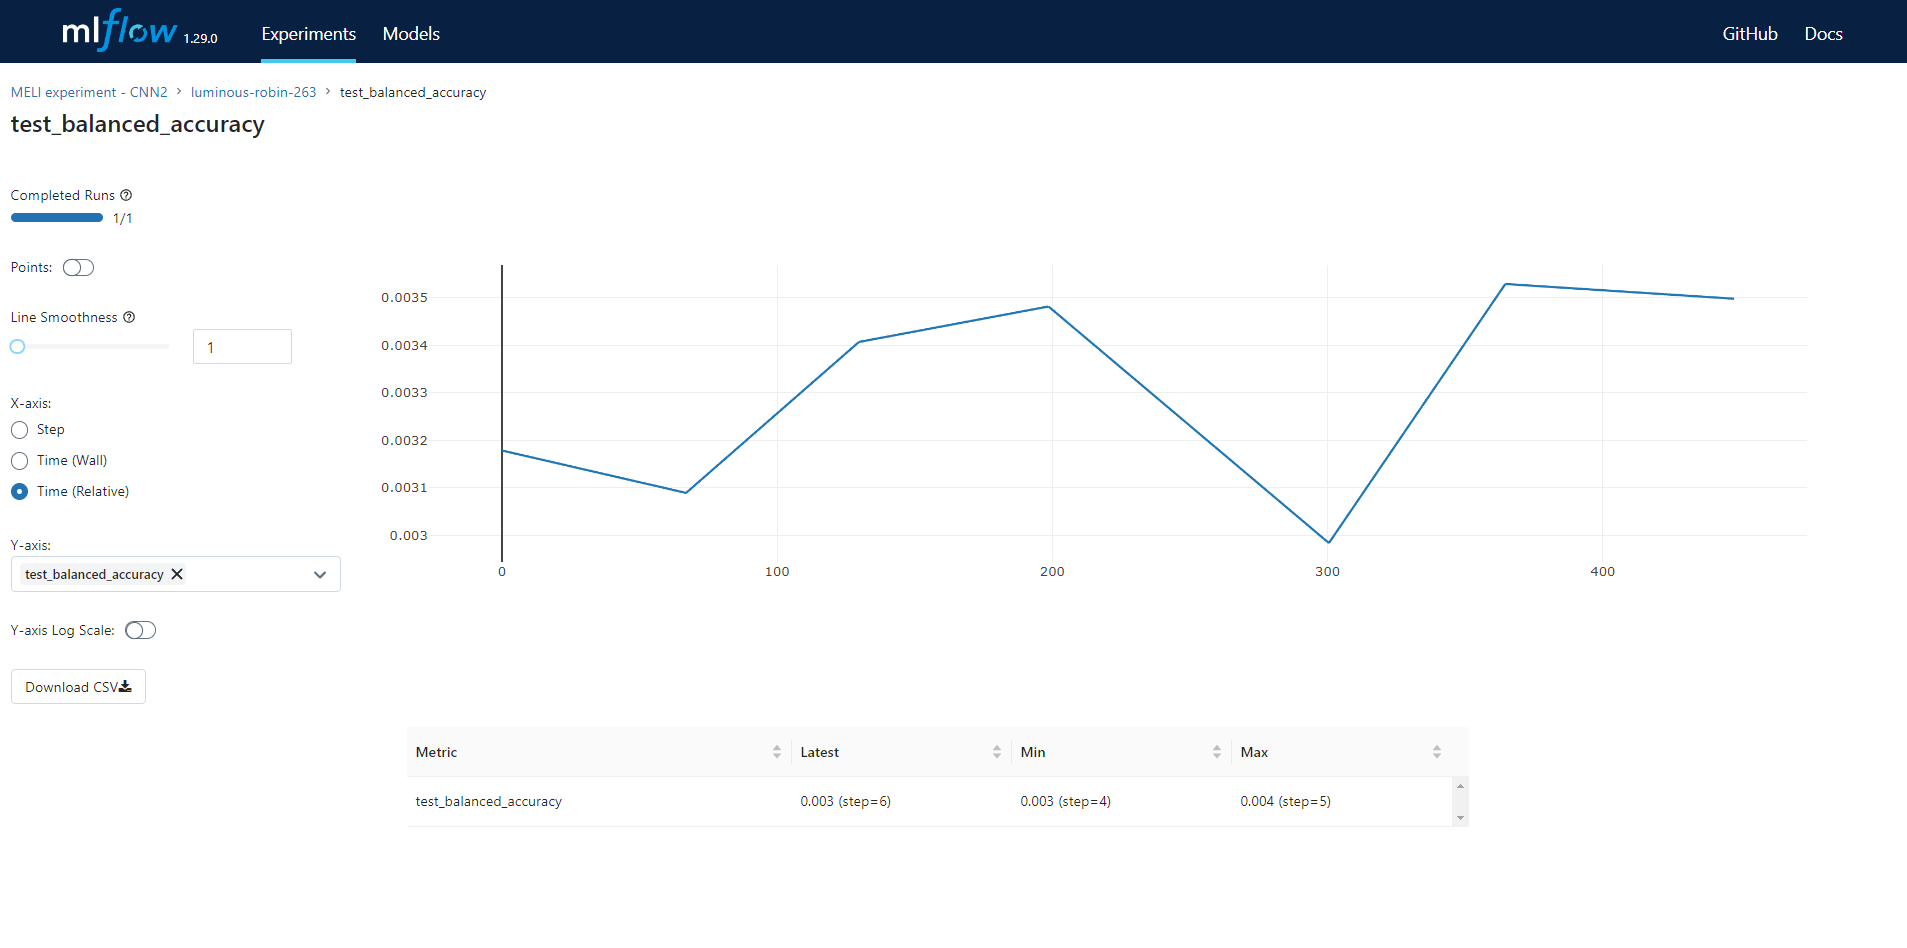

#### Loss

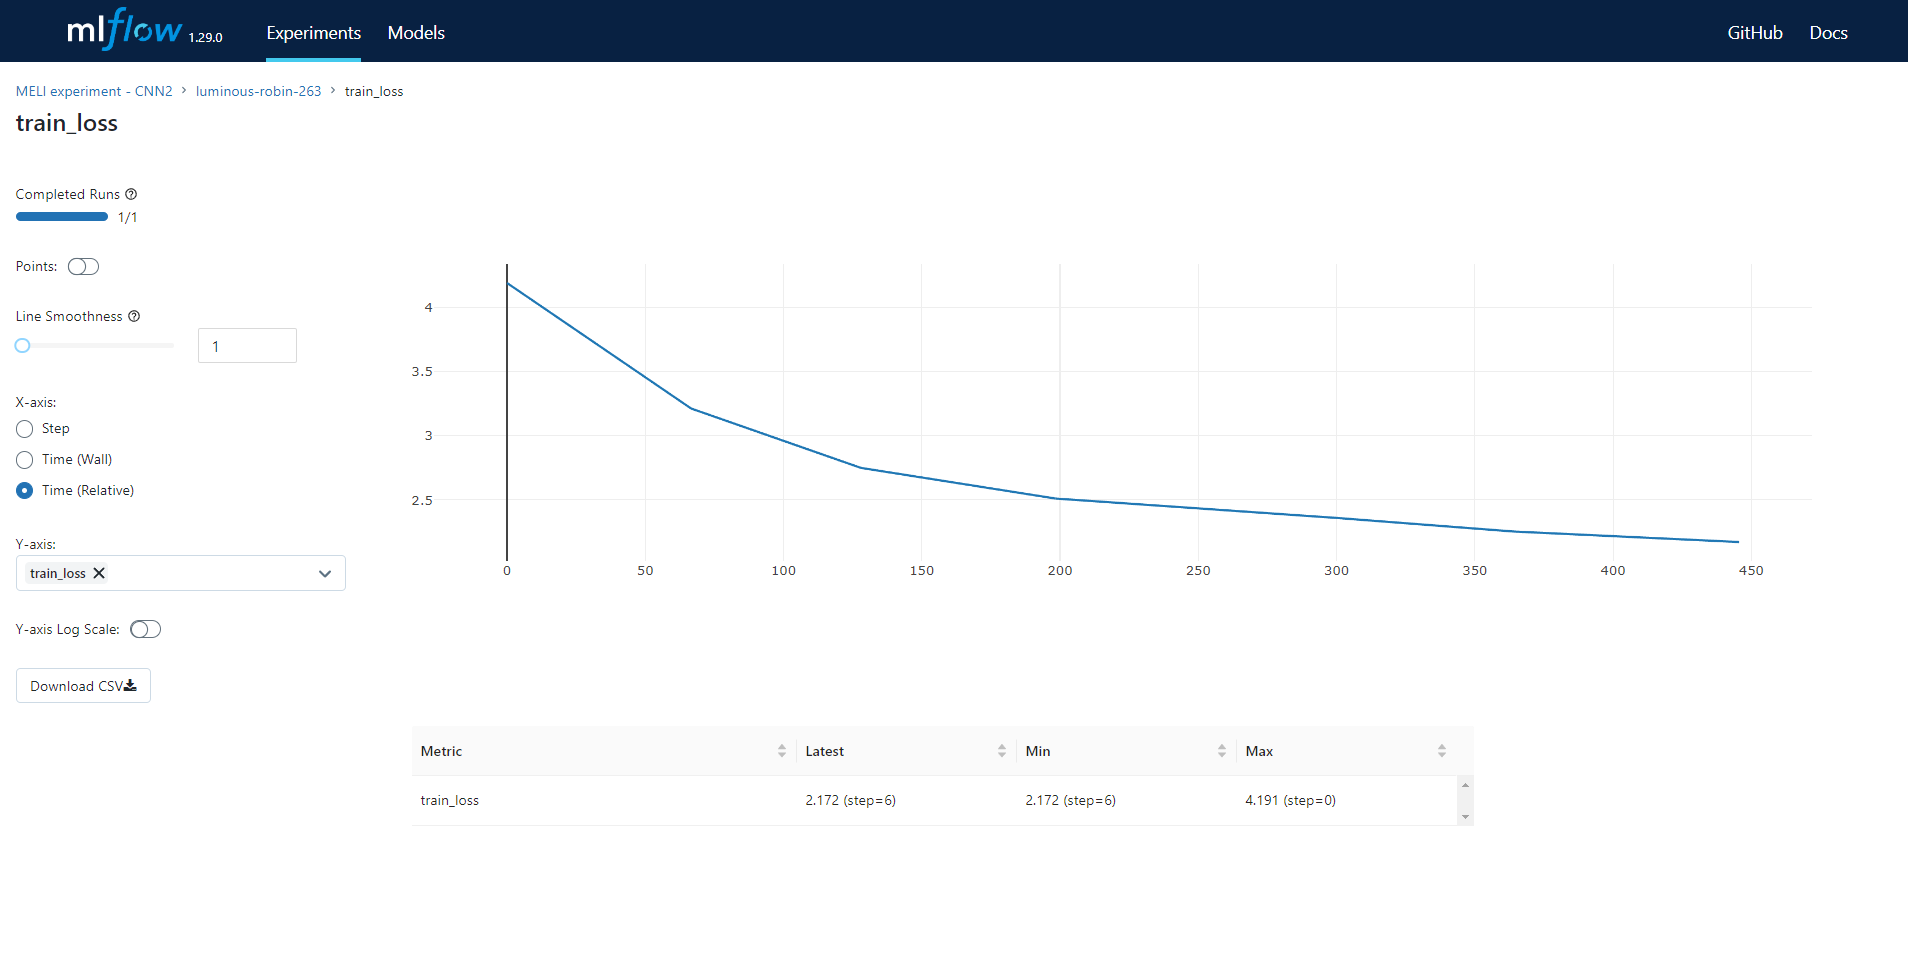

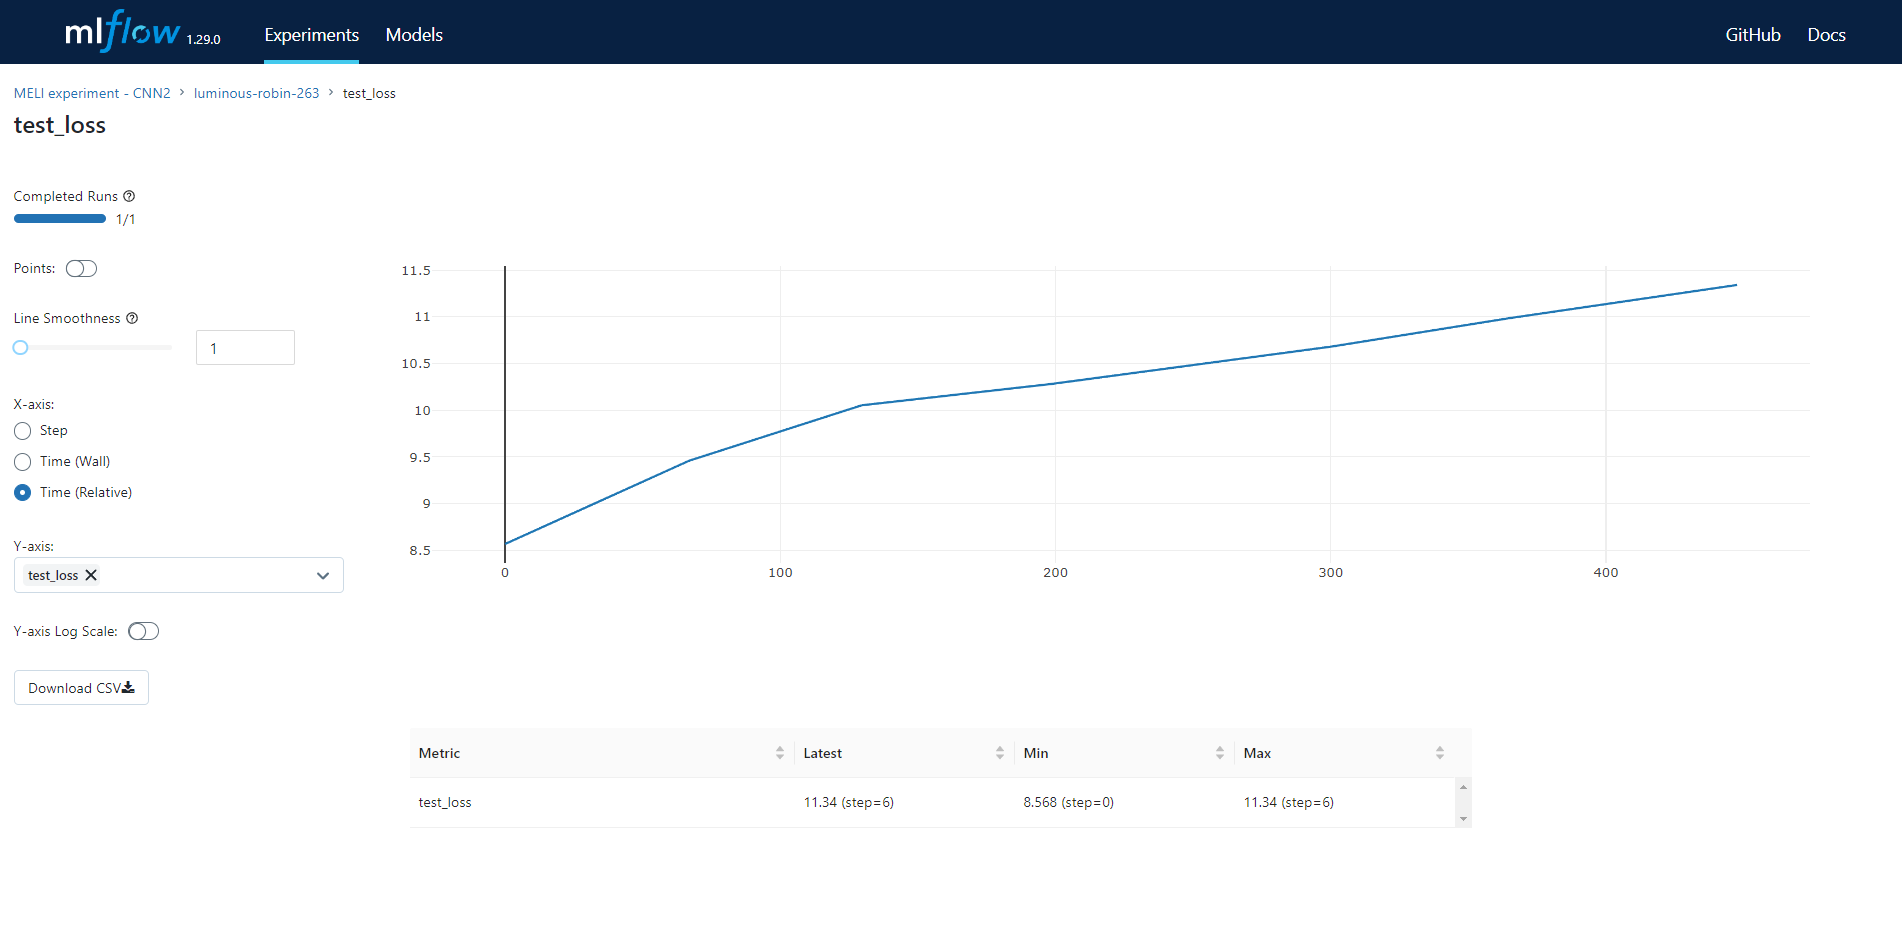

## Conclusiones

A lo largo del trabajo se probaron diferentes configuraciones y arquitecturas para mejorar la métrica *balanced accuracy*. 
Sin embargo, los resultados no fueron los esperados. En el conjunto de test, la balanced_accuracy siempre fue inferior a 0.4%. 
La decisiones respecto a cantidad de epocas y muestreo del dataset de train, fueron tomadas con el ojetivo de disminuir los tiempos de ejecución, teniendo en cuenta que el entrenamiento de los diferentes modelos demandaba mucho tiempo y la conexión a Nabu era significativamente inestable, lo cual dificultaba aun mas el desarrollo del trabajo.
Consideramos que utilizando la totalidad de los datos e incrementando la cantdad de épocas y tamaños de batches se podrían obtener mejores resultados.
Es muy probable que la elección de hiperparámetros (cantidad de capas, cantidad de nueronas por capas y funciones de activación) no haya sido la optima. Para futuros trabajos debemos contemplar la utilización de alguna técnica similar a Grid Search CV de sklearn